In [33]:
%reset -f

In [34]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt

### Read data

In [35]:
def read_data(data_dir):
    data = []  # List to store (benchmark, IPC value) tuples
    for file in os.listdir(data_dir):
        if file.endswith(".txt"):

            if os.path.getsize(os.path.join(data_dir, file)) == 0:
                print(f"File {file} is empty, directory: {data_dir}, skipping...")
                continue

            found_ipc = False
            with open(os.path.join(data_dir, file), "r") as f:
                for line in f:
                    if "CPU 0 cumulative IPC:" in line:
                        found_ipc = True
                        try:
                            # Extract the IPC value
                            ipc_value = float(
                                line.split("CPU 0 cumulative IPC:")[1].split()[0]
                            )
                            # Append to list
                            data.append((file.split(".txt")[0], ipc_value))
                        except (IndexError, ValueError):
                            print(f"Couldn't extract IPC value from line: {line}")

            if not found_ipc:
                print(f"IPC value not found in file: {file} in directory: {data_dir}")

    # Create DataFrame from the data
    df = pd.DataFrame(data, columns=["Benchmark", "IPC"])

    # Sort the DataFrame by Benchmark name
    df = df.sort_values(by=["Benchmark"])
    df = df.reset_index(drop=True)

    return df

In [36]:
cp_ipc_df = read_data("cp-data")
wp_ipc_df = read_data("wp-data")

In [37]:
def group_by(main_df, string):
    df = main_df[
        main_df["Benchmark"].str.contains(f"champsim-{string}$", regex=True)
    ].reset_index(drop=True)
    df["Benchmark"] = df["Benchmark"].str.replace(f"-champsim-{string}", "")

    # Calculate Geometric Mean
    try:
        geomean = math.prod(df["IPC"]) ** (1 / len(df["IPC"]))
        geomean_df = pd.DataFrame([{"Benchmark": "Geomean", "IPC": geomean}])
        df = pd.concat([df, geomean_df], ignore_index=True)
    except ZeroDivisionError:
        print(f"Some IPC values are zero in {string} data, exiting...")
        exit(1)

    return df

In [38]:
def calculate_speedup(df, baseline_df):
    df["Speedup"] = ((df["IPC"] / baseline_df["IPC"]) - 1) * 100
    return df

In [39]:
# Bar width and gap settings
bar_width = 0.1
gap = 0.2

## L1I

In [40]:
l1i_prefetchers = {
    "default": {"label": "FDIP", "color": "white", "edgecolor": "black", "hatch": "//"},
    "l1i-barsa": {"label": "Barsa"},
    "l1i-bip": {"label": "BIP"},
    "l1i-djolt": {"label": "Djolt"},
    "l1i-epi": {"label": "EPI"},
    "l1i-fnlmma": {"label": "FNL-MMA"},
    "l1i-fnlmma_new": {"label": "FNL-MMA New"},
    "l1i-mana": {"label": "Mana"},
    "l1i-next_line": {"label": "Next Line"},
    "l1i-pips": {"label": "PIPS"},
    "l1i-tap": {"label": "TAP"},
}

### Correct Path

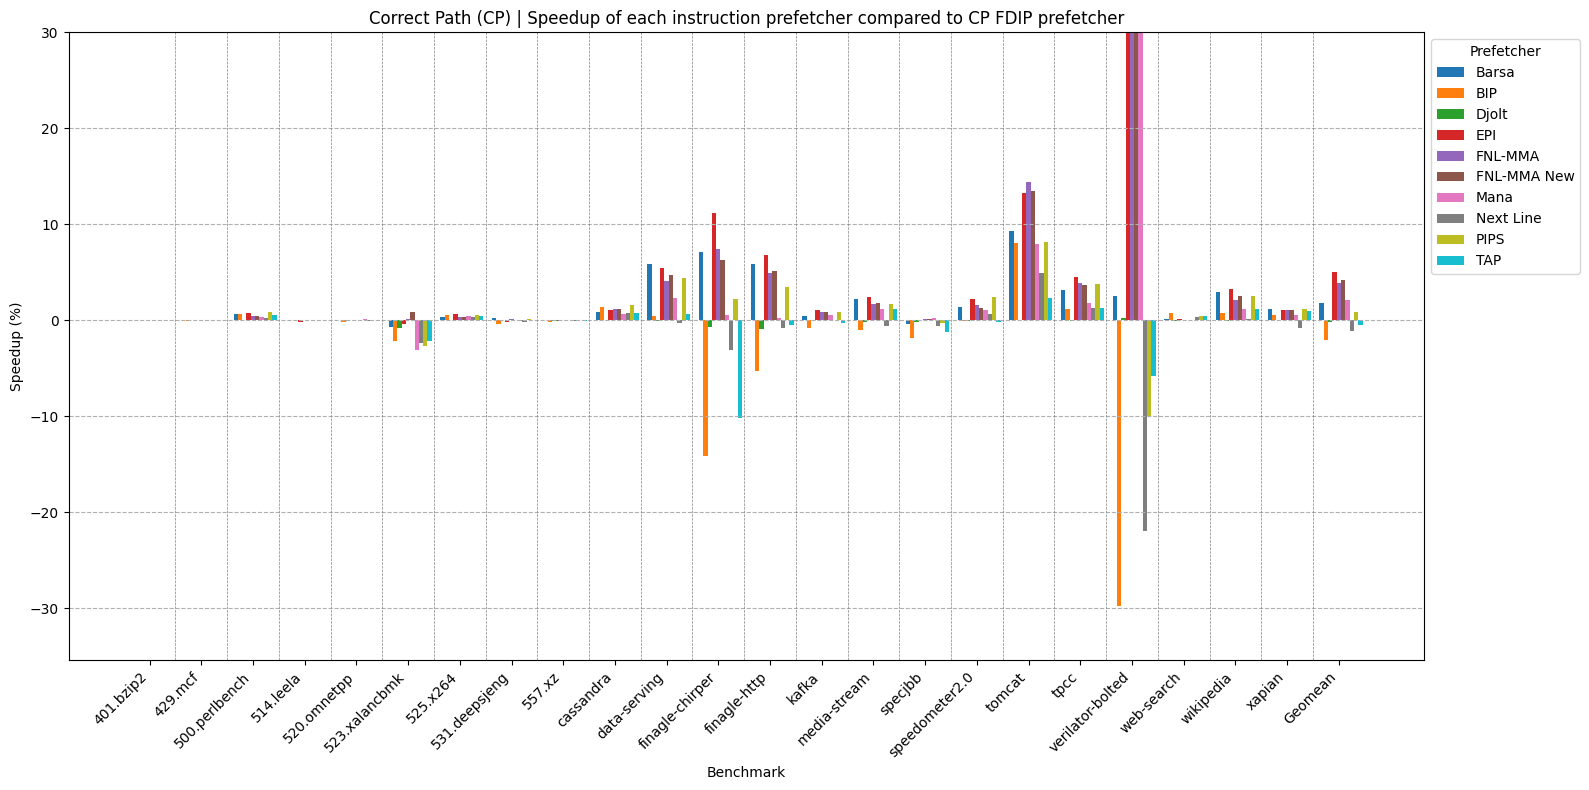

In [41]:
# Group data by prefetcher and calculate speedup
df_speedup_cp = {}
df_cp_default = group_by(cp_ipc_df, "default")
for key in l1i_prefetchers:
    if key != "default":
        df_cp = group_by(cp_ipc_df, key)
        df_speedup_cp[key] = calculate_speedup(df_cp, df_cp_default)

# Create positions for each bar group
r_base = [x * (1 + gap) for x in range(len(df_cp_default))]
r_positions = {}
for idx, key in enumerate(l1i_prefetchers):
    r_positions[key] = [x + idx * bar_width for x in r_base]

# Create the plot
plt.figure(figsize=(16, 8))

# Plot each prefetcher
for key, props in l1i_prefetchers.items():
    if key != "default":
        plt.bar(
            r_positions[key],
            df_speedup_cp[key]["Speedup"],
            width=bar_width,
            label=props["label"],
        )

# Add vertical dashed lines between groups
for i in range(1, len(df_cp_default)):
    plt.axvline(x=(r_base[i] - gap / 2), color="gray", linestyle="--", linewidth=0.5)

# Add labels and title
plt.grid(axis="y", linestyle="--")
plt.xticks(
    [r + (len(l1i_prefetchers) - 1) * bar_width / 2 for r in r_base],
    df_cp_default["Benchmark"],
    rotation=45,
    ha="right",
)
plt.xlabel("Benchmark")
plt.ylabel("Speedup (%)")
plt.ylim(top=30)
plt.legend(title="Prefetcher", bbox_to_anchor=(1, 1), loc="upper left")
plt.title(
    "Correct Path (CP) | Speedup of each instruction prefetcher compared to CP FDIP prefetcher"
)
plt.tight_layout()
plt.show()

### Wrong Path

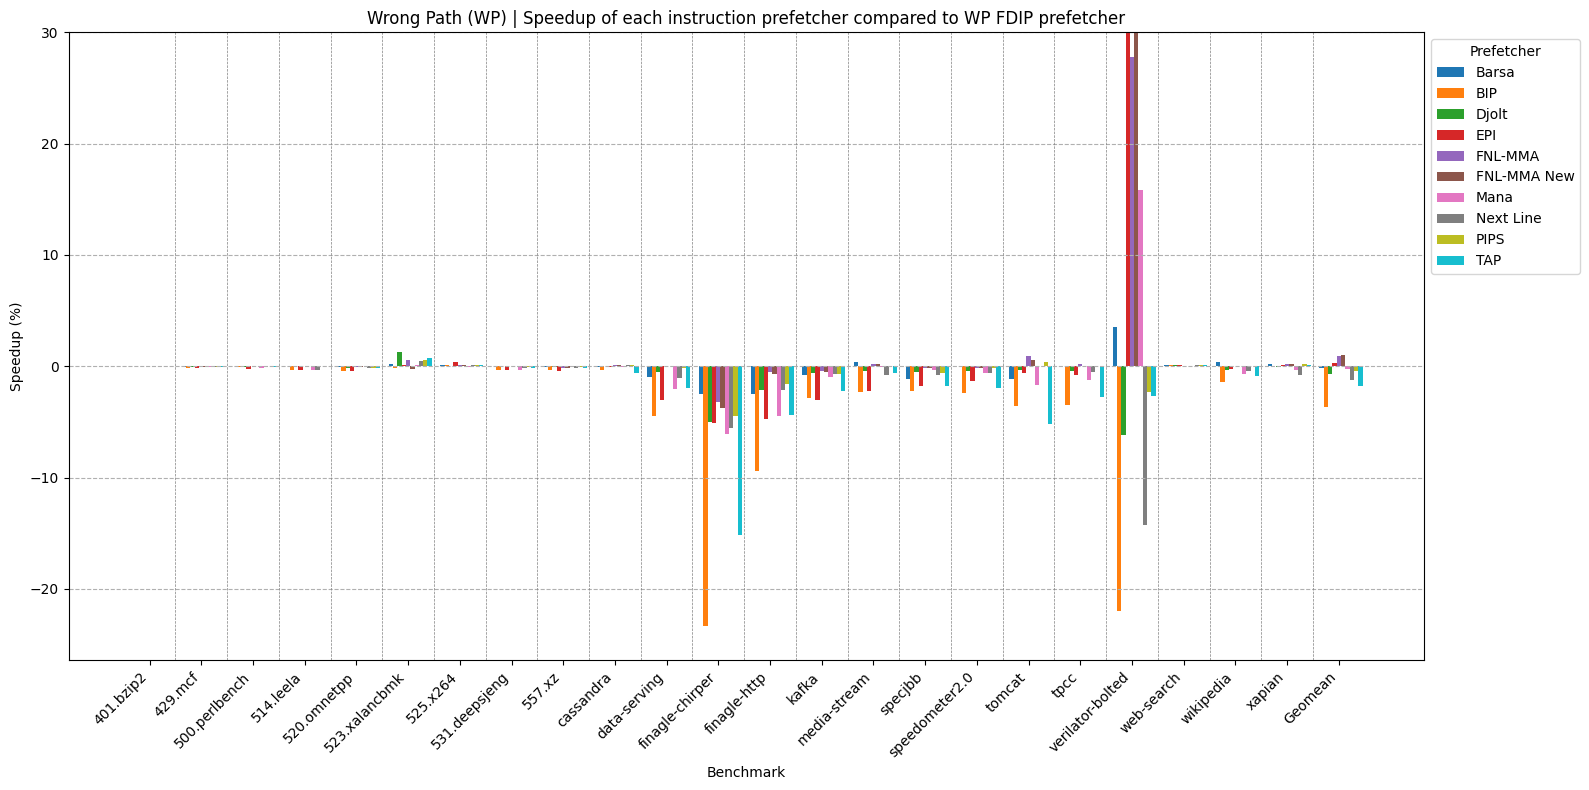

In [42]:
# Group data by prefetcher and calculate speedup
df_speedup_cp = {}
df_wp_default = group_by(wp_ipc_df, "default")
for key in l1i_prefetchers:
    if key != "default":
        df_wp = group_by(wp_ipc_df, key)
        df_speedup_cp[key] = calculate_speedup(df_wp, df_wp_default)

# Create positions for each bar group
r_base = [x * (1 + gap) for x in range(len(df_wp_default))]
r_positions = {}
for idx, key in enumerate(l1i_prefetchers):
    r_positions[key] = [x + idx * bar_width for x in r_base]

# Create the plot
plt.figure(figsize=(16, 8))

# Plot each prefetcher
for key, props in l1i_prefetchers.items():
    if key != "default":
        plt.bar(
            r_positions[key],
            df_speedup_cp[key]["Speedup"],
            width=bar_width,
            label=props["label"],
        )

# Add vertical dashed lines between groups
for i in range(1, len(df_wp_default)):
    plt.axvline(x=(r_base[i] - gap / 2), color="gray", linestyle="--", linewidth=0.5)

# Add labels and title
plt.grid(axis="y", linestyle="--")
plt.xticks(
    [r + (len(l1i_prefetchers) - 1) * bar_width / 2 for r in r_base],
    df_wp_default["Benchmark"],
    rotation=45,
    ha="right",
)
plt.xlabel("Benchmark")
plt.ylabel("Speedup (%)")
plt.ylim(top=30)
plt.legend(title="Prefetcher", bbox_to_anchor=(1, 1), loc="upper left")
plt.title(
    "Wrong Path (WP) | Speedup of each instruction prefetcher compared to WP FDIP prefetcher"
)
plt.tight_layout()
plt.show()

### WP Prefetchers v CP Baseline 

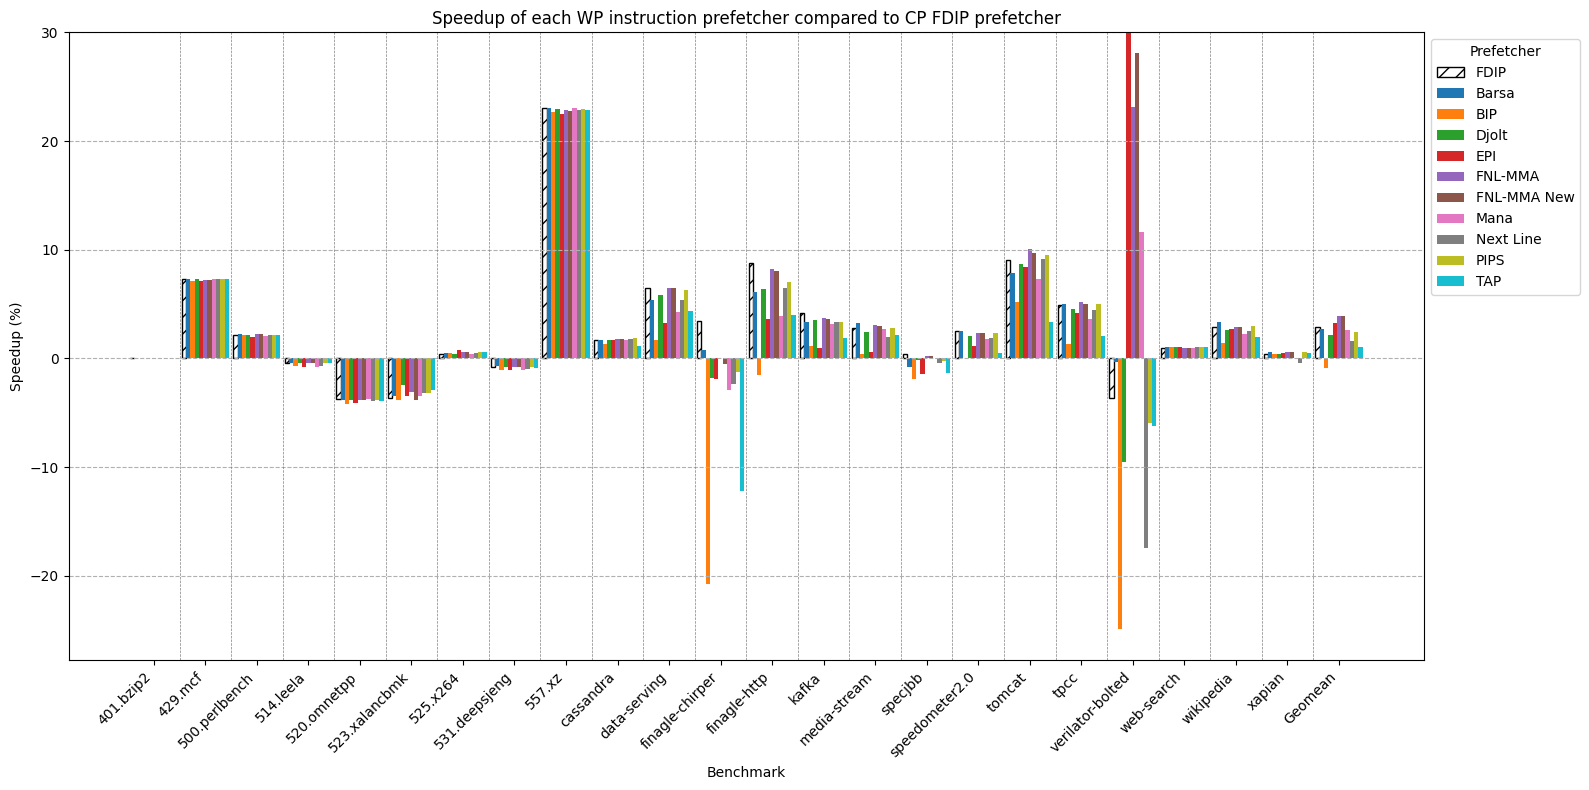

In [43]:
# Group data by prefetcher and calculate speedup
df_cp_default = group_by(cp_ipc_df, "default")
df_speedup_wp = {}
for key in l1i_prefetchers:
    df_wp = group_by(wp_ipc_df, key)
    df_speedup_wp[key] = calculate_speedup(df_wp, df_cp_default)

# Create positions for each bar group
r_base = [x * (1 + gap) for x in range(len(df_cp_default))]
r_positions = {}
for idx, key in enumerate(l1i_prefetchers):
    r_positions[key] = [x + idx * bar_width for x in r_base]

# Create the plot
plt.figure(figsize=(16, 8))

# Plot each prefetcher
for key, props in l1i_prefetchers.items():
    color = props.get("color", None)
    edgecolor = props.get("edgecolor", None)
    hatch = props.get("hatch", None)
    plt.bar(
        r_positions[key],
        df_speedup_wp[key]["Speedup"],
        width=bar_width,
        label=props["label"],
        color=color,
        edgecolor=edgecolor,
        hatch=hatch,
    )

# Add vertical dashed lines between groups
for i in range(1, len(df_cp_default)):
    plt.axvline(x=(r_base[i] - gap / 2), color="gray", linestyle="--", linewidth=0.5)

# Add labels and title
plt.grid(axis="y", linestyle="--")
plt.xticks(
    [r + (len(l1i_prefetchers) - 1) * bar_width / 2 for r in r_base],
    df_cp_default["Benchmark"],
    rotation=45,
    ha="right",
)
plt.xlabel("Benchmark")
plt.ylabel("Speedup (%)")
plt.ylim(top=30)
plt.legend(title="Prefetcher", bbox_to_anchor=(1, 1), loc="upper left")
plt.title("Speedup of each WP instruction prefetcher compared to CP FDIP prefetcher")
plt.tight_layout()
plt.show()

### WP Prefetchers v CP Prefetchers

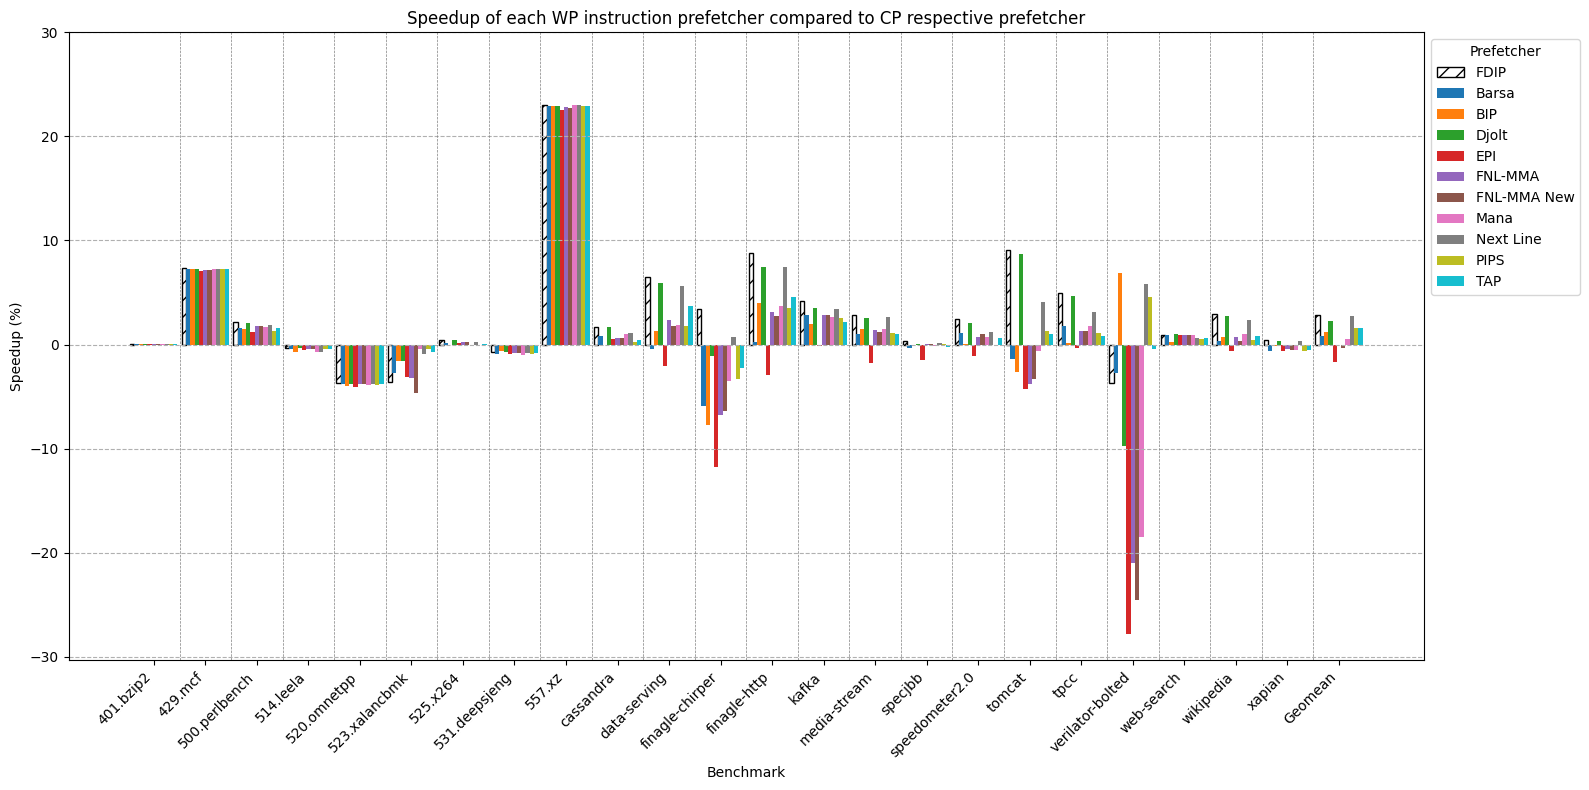

In [44]:
# Group data by prefetcher and calculate speedup
df_speedup_wp = {}
for key in l1i_prefetchers:
    df_wp = group_by(wp_ipc_df, key)
    df_cp = group_by(cp_ipc_df, key)
    df_speedup_wp[key] = calculate_speedup(df_wp, df_cp)

# Create positions for each bar group
r_base = [x * (1 + gap) for x in range(len(df_speedup_wp["default"]))]
r_positions = {}
for idx, key in enumerate(l1i_prefetchers):
    r_positions[key] = [x + idx * bar_width for x in r_base]

# Create the plot
plt.figure(figsize=(16, 8))

# Plot each prefetcher
for key, props in l1i_prefetchers.items():
    color = props.get("color", None)
    edgecolor = props.get("edgecolor", None)
    hatch = props.get("hatch", None)
    plt.bar(
        r_positions[key],
        df_speedup_wp[key]["Speedup"],
        width=bar_width,
        label=props["label"],
        color=color,
        edgecolor=edgecolor,
        hatch=hatch,
    )

# Add vertical dashed lines between groups
for i in range(1, len(r_base)):
    plt.axvline(x=(r_base[i] - gap / 2), color="gray", linestyle="--", linewidth=0.5)

# Add labels and title for WP plot
plt.grid(axis="y", linestyle="--")
plt.xticks(
    [r + (len(l1i_prefetchers) - 1) * bar_width / 2 for r in r_base],
    df_speedup_wp["default"]["Benchmark"],
    rotation=45,
    ha="right",
)
plt.xlabel("Benchmark")
plt.ylabel("Speedup (%)")
plt.ylim(top=30)
plt.legend(title="Prefetcher", bbox_to_anchor=(1, 1), loc="upper left")
plt.title(
    "Speedup of each WP instruction prefetcher compared to CP respective prefetcher"
)
plt.tight_layout()
plt.show()

## L1D

In [45]:
l1d_prefetchers = {
    "default": {"label": "None", "color": "white", "edgecolor": "black", "hatch": "//"},
    "l1d-berti": {"label": "BERTI"},
    "l1d-ip_stride": {"label": "IP Stride"},
    "l1d-ipcp": {"label": "IPCP"},
    "l1d-next_line": {"label": "Next Line"},
}

### Correct Path

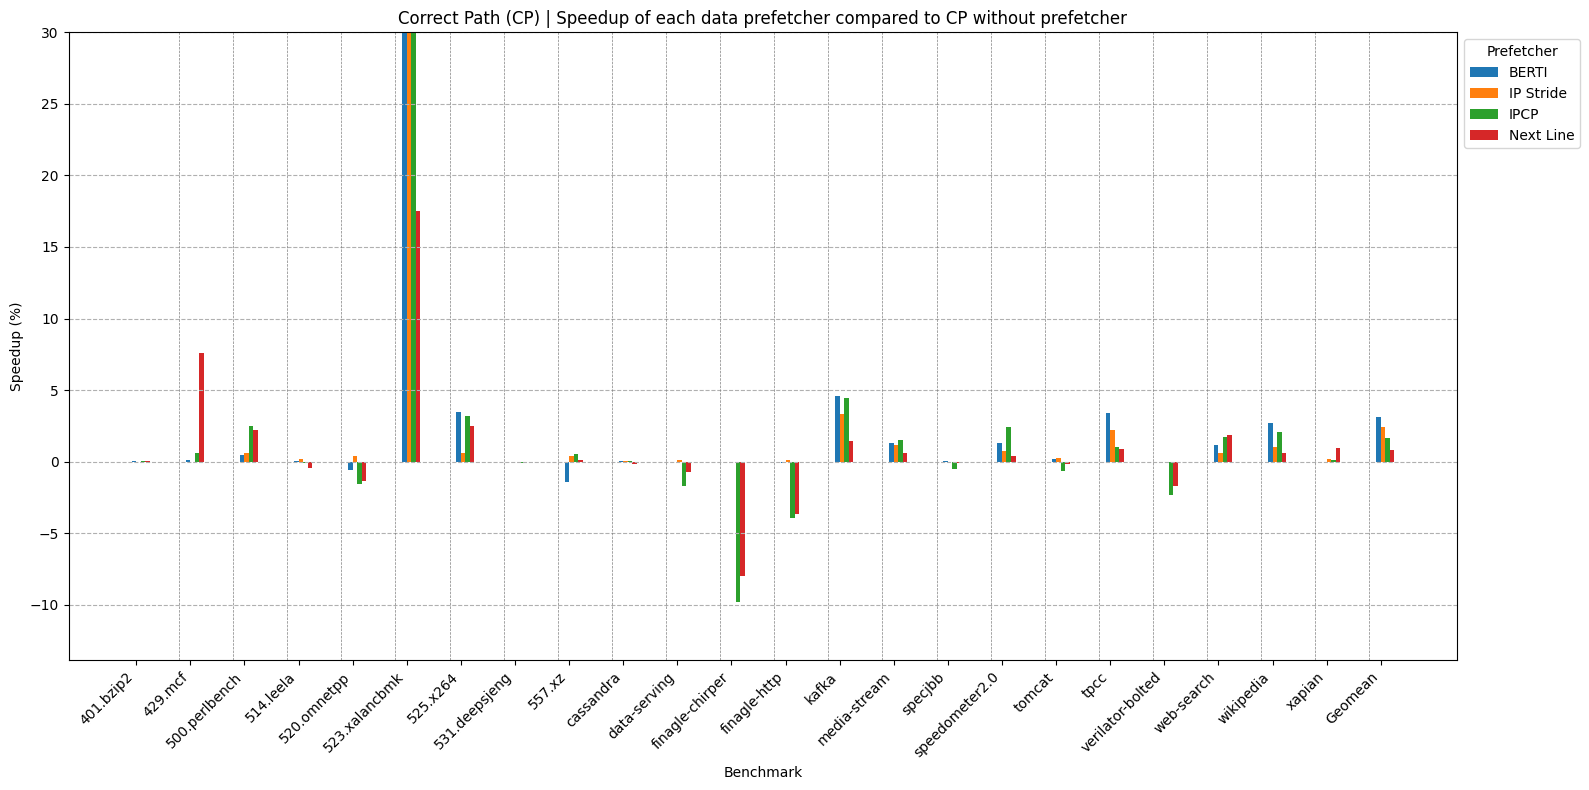

In [46]:
# Group data by prefetcher and calculate speedup
df_speedup_cp = {}
df_cp_default = group_by(cp_ipc_df, "default")
for key in l1d_prefetchers:
    if key != "default":
        df_cp = group_by(cp_ipc_df, key)
        df_speedup_cp[key] = calculate_speedup(df_cp, df_cp_default)

# Create positions for each bar group
r_base = [x * (1 + gap) for x in range(len(df_cp_default))]
r_positions = {}
for idx, key in enumerate(l1d_prefetchers):
    r_positions[key] = [x + idx * bar_width for x in r_base]

# Create the plot
plt.figure(figsize=(16, 8))

# Plot each prefetcher
for key, props in l1d_prefetchers.items():
    if key != "default":
        plt.bar(
            r_positions[key],
            df_speedup_cp[key]["Speedup"],
            width=bar_width,
            label=props["label"],
        )

# Add vertical dashed lines between groups
for i in range(1, len(r_base)):
    plt.axvline(x=(r_base[i] - gap / 2), color="gray", linestyle="--", linewidth=0.5)

# Add labels and title
plt.grid(axis="y", linestyle="--")
plt.xticks(
    [r + (len(l1d_prefetchers) - 2) * bar_width / 2 for r in r_base],
    df_cp_default["Benchmark"],
    rotation=45,
    ha="right",
)
plt.xlabel("Benchmark")
plt.ylabel("Speedup (%)")
plt.ylim(top=30)
plt.legend(title="Prefetcher", bbox_to_anchor=(1, 1), loc="upper left")
plt.title(
    "Correct Path (CP) | Speedup of each data prefetcher compared to CP without prefetcher"
)
plt.tight_layout()
plt.show()

### Wrong Path

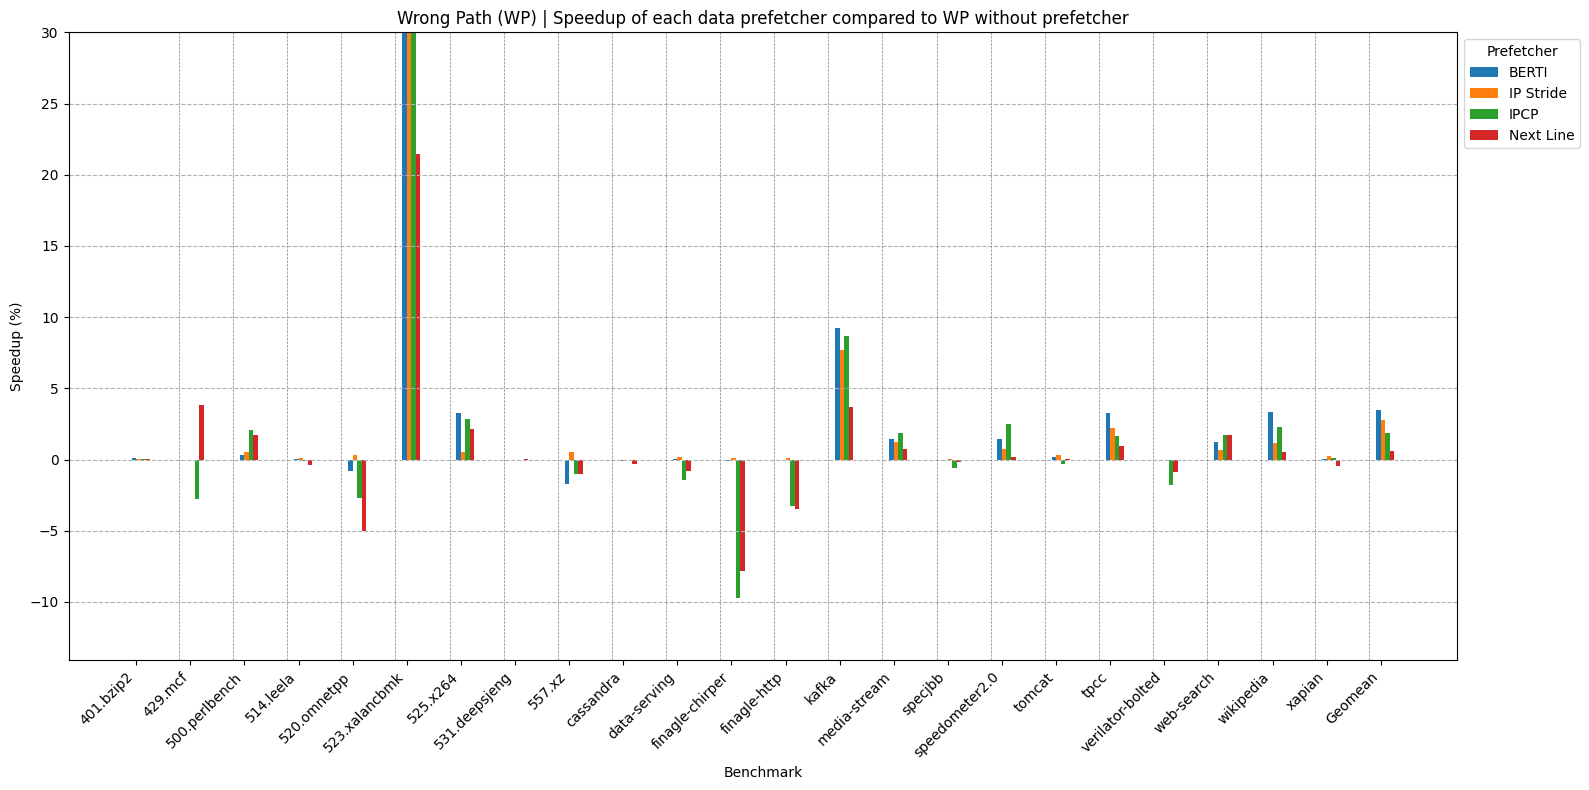

In [47]:
# Group data by prefetcher and calculate speedup
df_speedup_wp = {}
df_wp_default = group_by(wp_ipc_df, "default")
for key in l1d_prefetchers:
    if key != "default":
        df_wp = group_by(wp_ipc_df, key)
        df_speedup_wp[key] = calculate_speedup(df_wp, df_wp_default)

# Create positions for each bar group
r_base = [x * (1 + gap) for x in range(len(df_wp_default))]
r_positions = {}
for idx, key in enumerate(l1d_prefetchers):
    r_positions[key] = [x + idx * bar_width for x in r_base]

# Create the plot
plt.figure(figsize=(16, 8))

# Plot each prefetcher
for key, props in l1d_prefetchers.items():
    if key != "default":
        plt.bar(
            r_positions[key],
            df_speedup_wp[key]["Speedup"],
            width=bar_width,
            label=props["label"],
        )

# Add vertical dashed lines between groups
for i in range(1, len(r_base)):
    plt.axvline(x=(r_base[i] - gap / 2), color="gray", linestyle="--", linewidth=0.5)

# Add labels and title
plt.grid(axis="y", linestyle="--")
plt.xticks(
    [r + (len(l1d_prefetchers) - 2) * bar_width / 2 for r in r_base],
    df_wp_default["Benchmark"],
    rotation=45,
    ha="right",
)
plt.xlabel("Benchmark")
plt.ylabel("Speedup (%)")
plt.ylim(top=30)
plt.legend(title="Prefetcher", bbox_to_anchor=(1, 1), loc="upper left")
plt.title(
    "Wrong Path (WP) | Speedup of each data prefetcher compared to WP without prefetcher"
)
plt.tight_layout()
plt.show()

### WP Prefetchers v CP Baseline

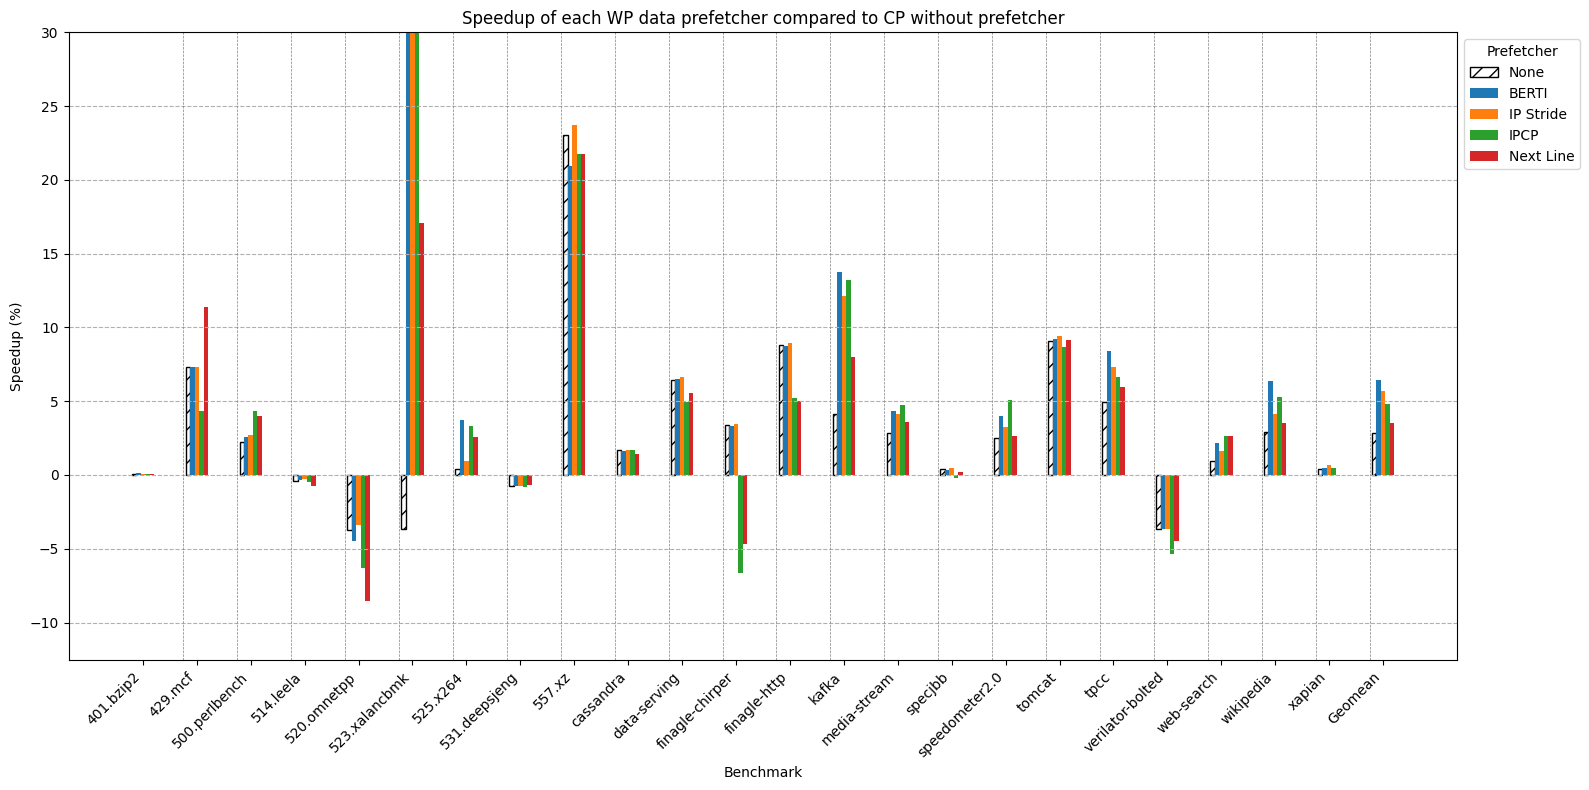

In [48]:
# Group data by prefetcher and calculate speedup
df_cp_default = group_by(cp_ipc_df, "default")
df_speedup_wp = {}
for key in l1d_prefetchers:
    df_wp = group_by(wp_ipc_df, key)
    df_speedup_wp[key] = calculate_speedup(df_wp, df_cp_default)

# Create positions for each bar group
r_base = [x * (1 + gap) for x in range(len(df_cp_default))]
r_positions = {}
for idx, key in enumerate(l1d_prefetchers):
    r_positions[key] = [x + idx * bar_width for x in r_base]

# Create the plot
plt.figure(figsize=(16, 8))

# Plot each prefetcher
for key, props in l1d_prefetchers.items():
    color = props.get("color", None)
    edgecolor = props.get("edgecolor", None)
    hatch = props.get("hatch", None)
    plt.bar(
        r_positions[key],
        df_speedup_wp[key]["Speedup"],
        width=bar_width,
        label=props["label"],
        color=color,
        edgecolor=edgecolor,
        hatch=hatch,
    )

# Add vertical dashed lines between groups
for i in range(1, len(r_base)):
    plt.axvline(x=(r_base[i] - gap / 2), color="gray", linestyle="--", linewidth=0.5)

# Add labels and title
plt.grid(axis="y", linestyle="--")
plt.xticks(
    [r + (len(l1d_prefetchers) - 1) * bar_width / 2 for r in r_base],
    df_cp_default["Benchmark"],
    rotation=45,
    ha="right",
)
plt.xlabel("Benchmark")
plt.ylabel("Speedup (%)")
plt.ylim(top=30)
plt.legend(title="Prefetcher", bbox_to_anchor=(1, 1), loc="upper left")
plt.title("Speedup of each WP data prefetcher compared to CP without prefetcher")
plt.tight_layout()
plt.show()

### WP Prefetcheres v CP Prefetchers

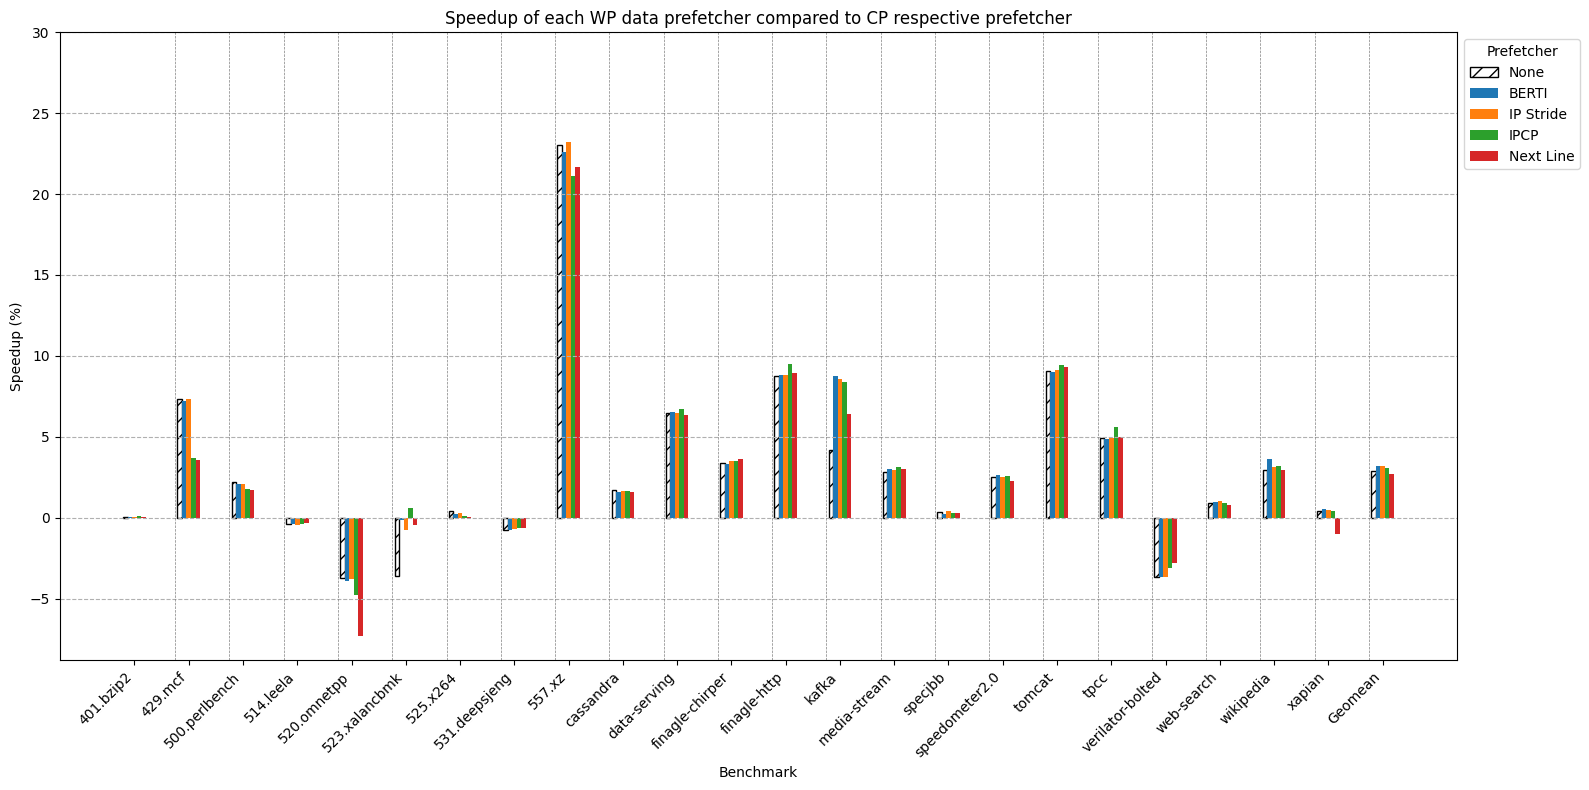

In [49]:
# Group data by prefetcher and calculate speedup
df_speedup_wp = {}
for key in l1d_prefetchers:
    df_wp = group_by(wp_ipc_df, key)
    df_cp = group_by(cp_ipc_df, key)
    df_speedup_wp[key] = calculate_speedup(df_wp, df_cp)

# Create positions for each bar group
r_base = [x * (1 + gap) for x in range(len(df_speedup_wp["default"]))]
r_positions = {}
for idx, key in enumerate(l1d_prefetchers):
    r_positions[key] = [x + idx * bar_width for x in r_base]

# Create the plot
plt.figure(figsize=(16, 8))

# Plot each prefetcher
for key, props in l1d_prefetchers.items():
    color = props.get("color", None)
    edgecolor = props.get("edgecolor", None)
    hatch = props.get("hatch", None)
    plt.bar(
        r_positions[key],
        df_speedup_wp[key]["Speedup"],
        width=bar_width,
        label=props["label"],
        color=color,
        edgecolor=edgecolor,
        hatch=hatch,
    )

# Add vertical dashed lines between groups
for i in range(1, len(r_base)):
    plt.axvline(x=(r_base[i] - gap / 2), color="gray", linestyle="--", linewidth=0.5)

# Add labels and title
plt.grid(axis="y", linestyle="--")
plt.xticks(
    [r + (len(l1d_prefetchers) - 1) * bar_width / 2 for r in r_base],
    df_speedup_wp["default"]["Benchmark"],
    rotation=45,
    ha="right",
)
plt.xlabel("Benchmark")
plt.ylabel("Speedup (%)")
plt.ylim(top=30)
plt.legend(title="Prefetcher", bbox_to_anchor=(1, 1), loc="upper left")
plt.title("Speedup of each WP data prefetcher compared to CP respective prefetcher")
plt.tight_layout()
plt.show()

## L2C

In [50]:
l2c_prefetchers = {
    "default": {"label": "None", "color": "white", "edgecolor": "black", "hatch": "//"},
    # "l2c-ampm": {"label": "AMPM"}, # Skipping for better visualization
    "l2c-bingo": {"label": "Bingo"},
    "l2c-bop": {"label": "BOP"},
    # "l2c-dspatch": {"label": "DSPatch"}, # Skipping for better visualization
    "l2c-ip_stride": {"label": "IP Stride"},
    "l2c-ipcp": {"label": "IPCP"},
    "l2c-mlop": {"label": "MLOP"},
    # "l2c-next_line": {"label": "Next Line"}, # Skipping for better visualization
    "l2c-sandbox": {"label": "Sandbox"},
    "l2c-scooby": {"label": "Scooby"},
    "l2c-sms": {"label": "SMS"},
    "l2c-spp_dev": {"label": "SPP-Dev"},
    "l2c-spp_ppf_dev": {"label": "SPP-PPF-Dev"},
    # "l2c-streamer": {"label": "Streamer"}, # Skipping for better visualization
}

### Correct Path

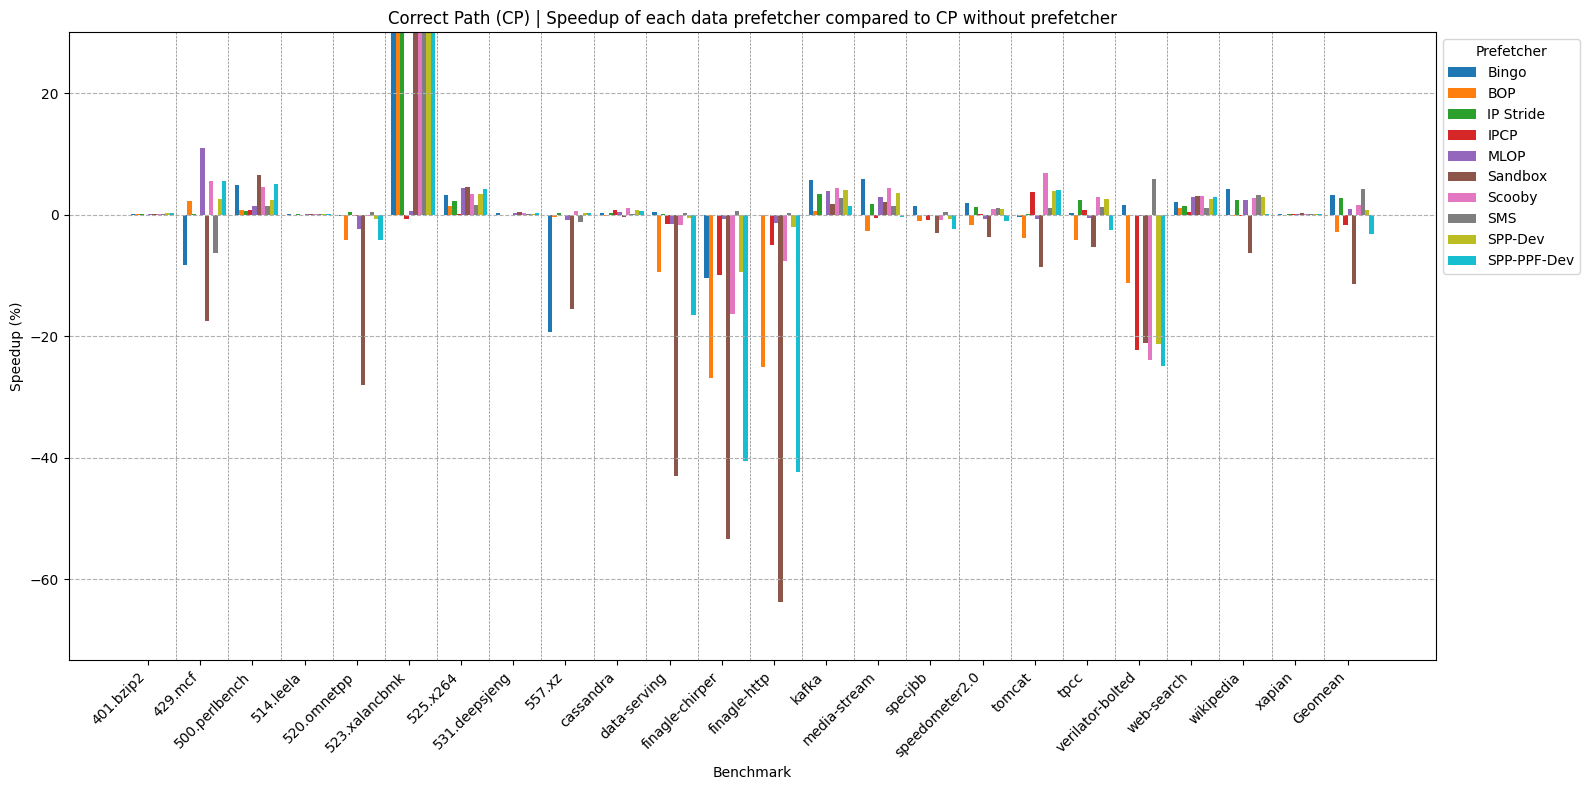

In [51]:
# Group data by prefetcher and calculate speedup
df_speedup_cp = {}
df_cp_default = group_by(cp_ipc_df, "default")
for key in l2c_prefetchers:
    if key != "default":
        df_cp = group_by(cp_ipc_df, key)
        df_speedup_cp[key] = calculate_speedup(df_cp, df_cp_default)

# Create positions for each bar group
r_base = [x * (1 + gap) for x in range(len(df_cp_default))]
r_positions = {}
for idx, key in enumerate(l2c_prefetchers):
    r_positions[key] = [x + idx * bar_width for x in r_base]

# Create the plot
plt.figure(figsize=(16, 8))

# Plot each prefetcher
for key, props in l2c_prefetchers.items():
    if key != "default":
        plt.bar(
            r_positions[key],
            df_speedup_cp[key]["Speedup"],
            width=bar_width,
            label=props["label"],
        )

# Add vertical dashed lines between groups
for i in range(1, len(r_base)):
    plt.axvline(x=(r_base[i] - (gap) / 2), color="gray", linestyle="--", linewidth=0.5)

# Add labels and title
plt.grid(axis="y", linestyle="--")
plt.xticks(
    [r + (len(l2c_prefetchers) - 2) * bar_width / 2 for r in r_base],
    df_cp_default["Benchmark"],
    rotation=45,
    ha="right",
)
plt.xlabel("Benchmark")
plt.ylabel("Speedup (%)")
plt.ylim(top=30)
plt.legend(title="Prefetcher", bbox_to_anchor=(1, 1), loc="upper left")
plt.title(
    "Correct Path (CP) | Speedup of each data prefetcher compared to CP without prefetcher"
)
plt.tight_layout()
plt.show()

### Wrong Path

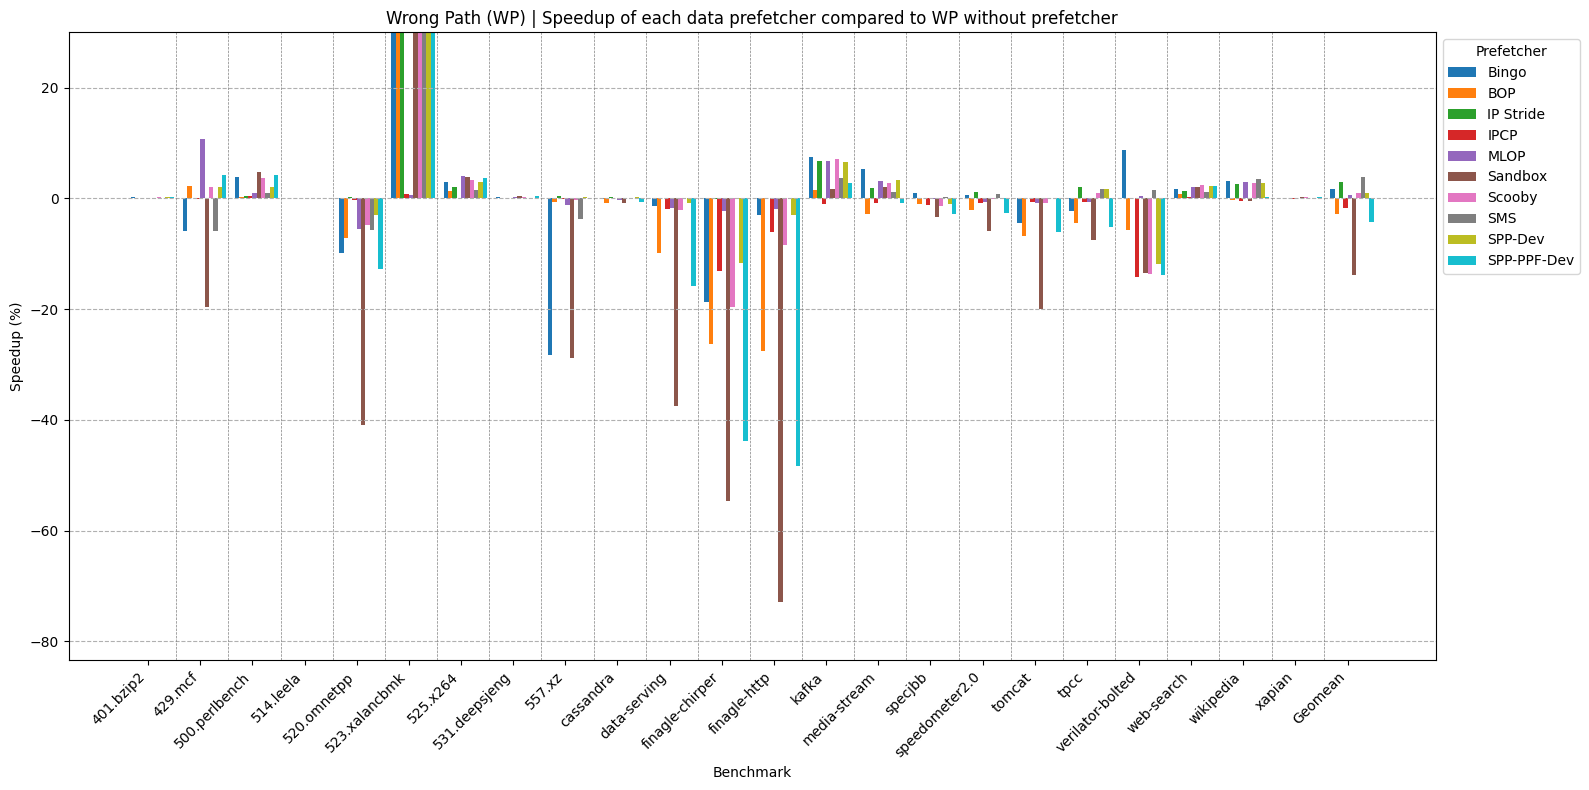

In [52]:
# Group data by prefetcher and calculate speedup
df_speedup_wp = {}
df_wp_default = group_by(wp_ipc_df, "default")
for key in l2c_prefetchers:
    if key != "default":
        df_wp = group_by(wp_ipc_df, key)
        df_speedup_wp[key] = calculate_speedup(df_wp, df_wp_default)

# Create positions for each bar group
r_base = [x * (1 + gap) for x in range(len(df_wp_default))]
r_positions = {}
for idx, key in enumerate(l2c_prefetchers):
    r_positions[key] = [x + idx * bar_width for x in r_base]

# Create the plot
plt.figure(figsize=(16, 8))

# Plot each prefetcher
for key, props in l2c_prefetchers.items():
    if key != "default":
        plt.bar(
            r_positions[key],
            df_speedup_wp[key]["Speedup"],
            width=bar_width,
            label=props["label"],
        )

# Add vertical dashed lines between groups
for i in range(1, len(r_base)):
    plt.axvline(x=(r_base[i] - gap / 2), color="gray", linestyle="--", linewidth=0.5)

# Add labels and title
plt.grid(axis="y", linestyle="--")
plt.xticks(
    [r + (len(l2c_prefetchers) - 2) * bar_width / 2 for r in r_base],
    df_wp_default["Benchmark"],
    rotation=45,
    ha="right",
)
plt.xlabel("Benchmark")
plt.ylabel("Speedup (%)")
plt.ylim(top=30)
plt.legend(title="Prefetcher", bbox_to_anchor=(1, 1), loc="upper left")
plt.title(
    "Wrong Path (WP) | Speedup of each data prefetcher compared to WP without prefetcher"
)
plt.tight_layout()
plt.show()

### WP Prefetchers v CP Baseline

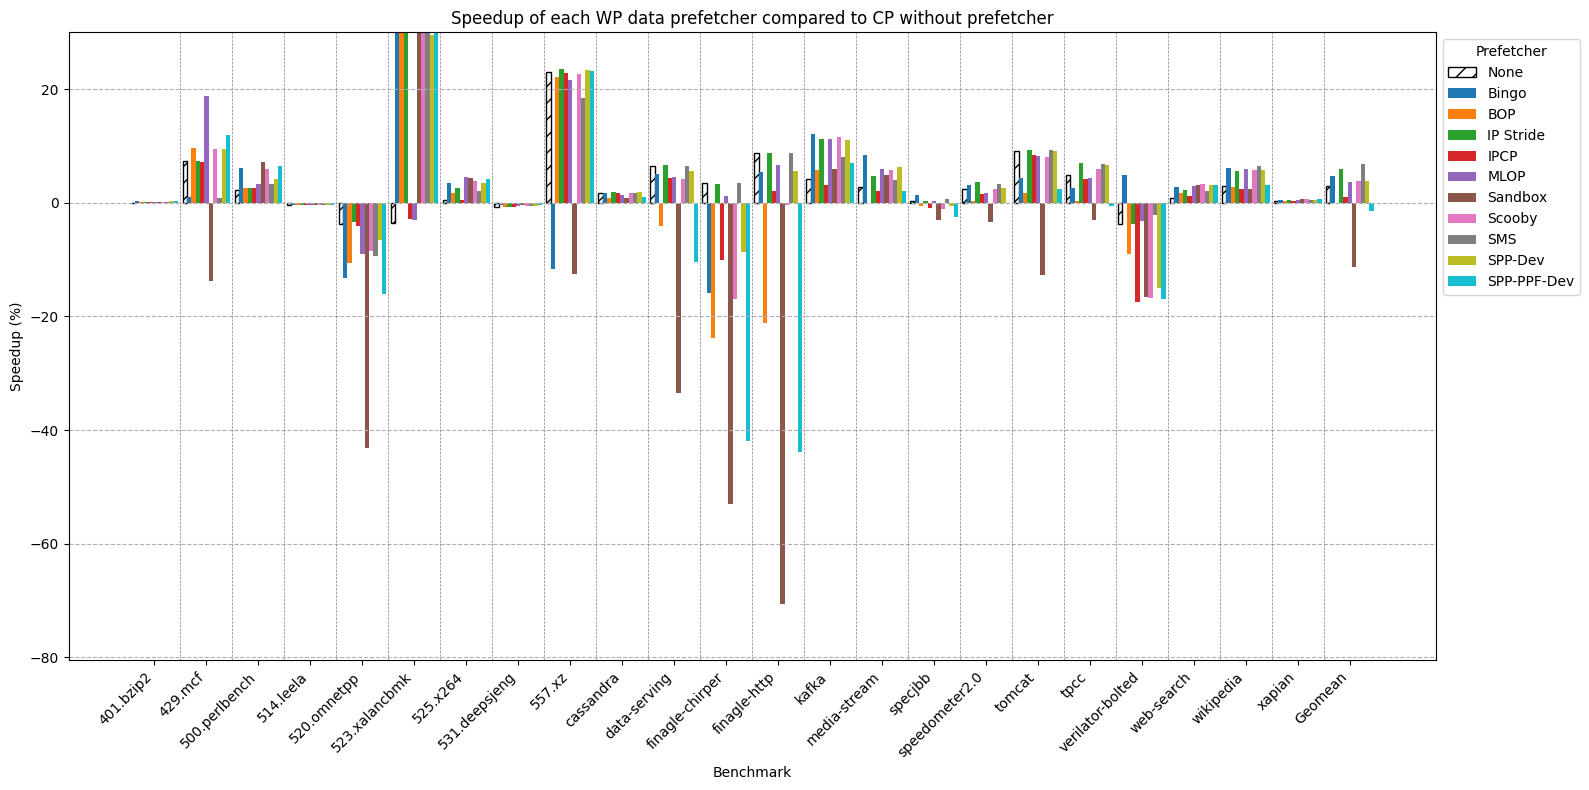

In [53]:
# Group data by prefetcher and calculate speedup
df_cp_default = group_by(cp_ipc_df, "default")
df_speedup_wp = {}
for key in l2c_prefetchers:
    df_wp = group_by(wp_ipc_df, key)
    df_speedup_wp[key] = calculate_speedup(df_wp, df_cp_default)

# Create positions for each bar group
r_base = [x * (1 + gap) for x in range(len(df_cp_default))]
r_positions = {}
for idx, key in enumerate(l2c_prefetchers):
    r_positions[key] = [x + idx * bar_width for x in r_base]

# Create the plot
plt.figure(figsize=(16, 8))

# Plot each prefetcher
for key, props in l2c_prefetchers.items():
    color = props.get("color", None)
    edgecolor = props.get("edgecolor", None)
    hatch = props.get("hatch", None)
    plt.bar(
        r_positions[key],
        df_speedup_wp[key]["Speedup"],
        width=bar_width,
        label=props["label"],
        color=color,
        edgecolor=edgecolor,
        hatch=hatch,
    )

# Add vertical dashed lines between groups
for i in range(1, len(r_base)):
    plt.axvline(x=(r_base[i] - gap / 2), color="gray", linestyle="--", linewidth=0.5)

# Add labels and title
plt.grid(axis="y", linestyle="--")
plt.xticks(
    [r + (len(l2c_prefetchers) - 1) * bar_width / 2 for r in r_base],
    df_cp_default["Benchmark"],
    rotation=45,
    ha="right",
)
plt.xlabel("Benchmark")
plt.ylabel("Speedup (%)")
plt.ylim(top=30)
plt.legend(title="Prefetcher", bbox_to_anchor=(1, 1), loc="upper left")
plt.title("Speedup of each WP data prefetcher compared to CP without prefetcher")
plt.tight_layout()
plt.show()

### WP Prefetchers v CP Prefetchers

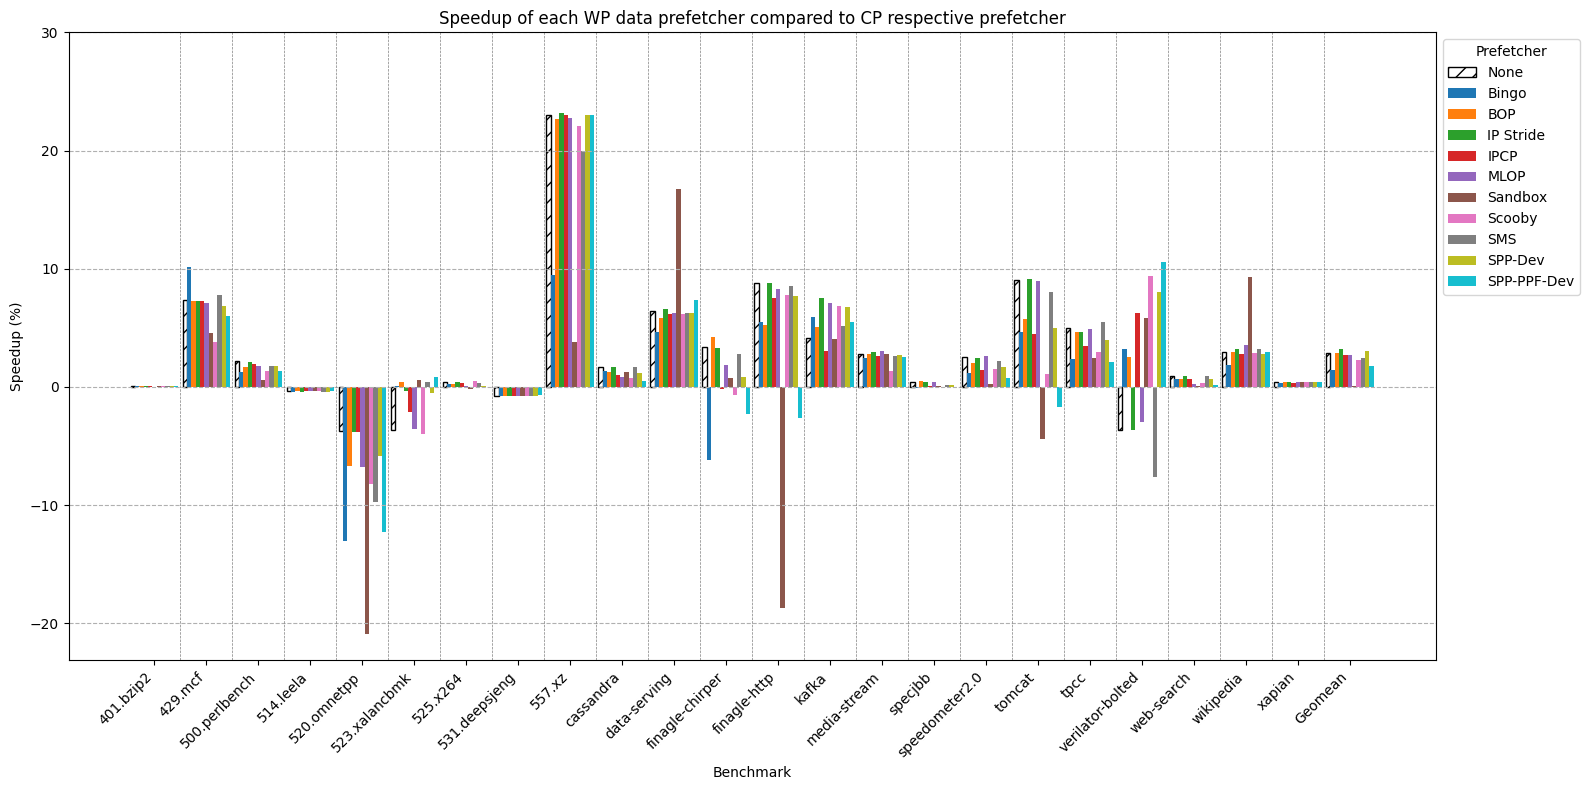

In [54]:
# Group data by prefetcher and calculate speedup
df_speedup_wp = {}
for key in l2c_prefetchers:
    df_wp = group_by(wp_ipc_df, key)
    df_cp = group_by(cp_ipc_df, key)
    df_speedup_wp[key] = calculate_speedup(df_wp, df_cp)

# Create positions for each bar group
r_base = [x * (1 + gap) for x in range(len(df_speedup_wp["default"]))]
r_positions = {}
for idx, key in enumerate(l2c_prefetchers):
    r_positions[key] = [x + idx * bar_width for x in r_base]

# Create the plot
plt.figure(figsize=(16, 8))

# Plot each prefetcher
for key, props in l2c_prefetchers.items():
    color = props.get("color", None)
    edgecolor = props.get("edgecolor", None)
    hatch = props.get("hatch", None)
    plt.bar(
        r_positions[key],
        df_speedup_wp[key]["Speedup"],
        width=bar_width,
        label=props["label"],
        color=color,
        edgecolor=edgecolor,
        hatch=hatch,
    )

# Add vertical dashed lines between groups
for i in range(1, len(r_base)):
    plt.axvline(x=(r_base[i] - gap / 2), color="gray", linestyle="--", linewidth=0.5)

# Add labels and title
plt.grid(axis="y", linestyle="--")
plt.xticks(
    [r + (len(l2c_prefetchers) - 1) * bar_width / 2 for r in r_base],
    df_speedup_wp["default"]["Benchmark"],
    rotation=45,
    ha="right",
)
plt.xlabel("Benchmark")
plt.ylabel("Speedup (%)")
plt.ylim(top=30)
plt.legend(title="Prefetcher", bbox_to_anchor=(1, 1), loc="upper left")
plt.title("Speedup of each WP data prefetcher compared to CP respective prefetcher")
plt.tight_layout()
plt.show()

## LLC

In [55]:
llc_prefetchers = {
    "default": {"label": "None", "color": "white", "edgecolor": "black", "hatch": "//"},
    "l2c-ip_stride": {"label": "IP Stride"},
    "l2c-next_line": {"label": "Next Line"},
}

### Correct Path

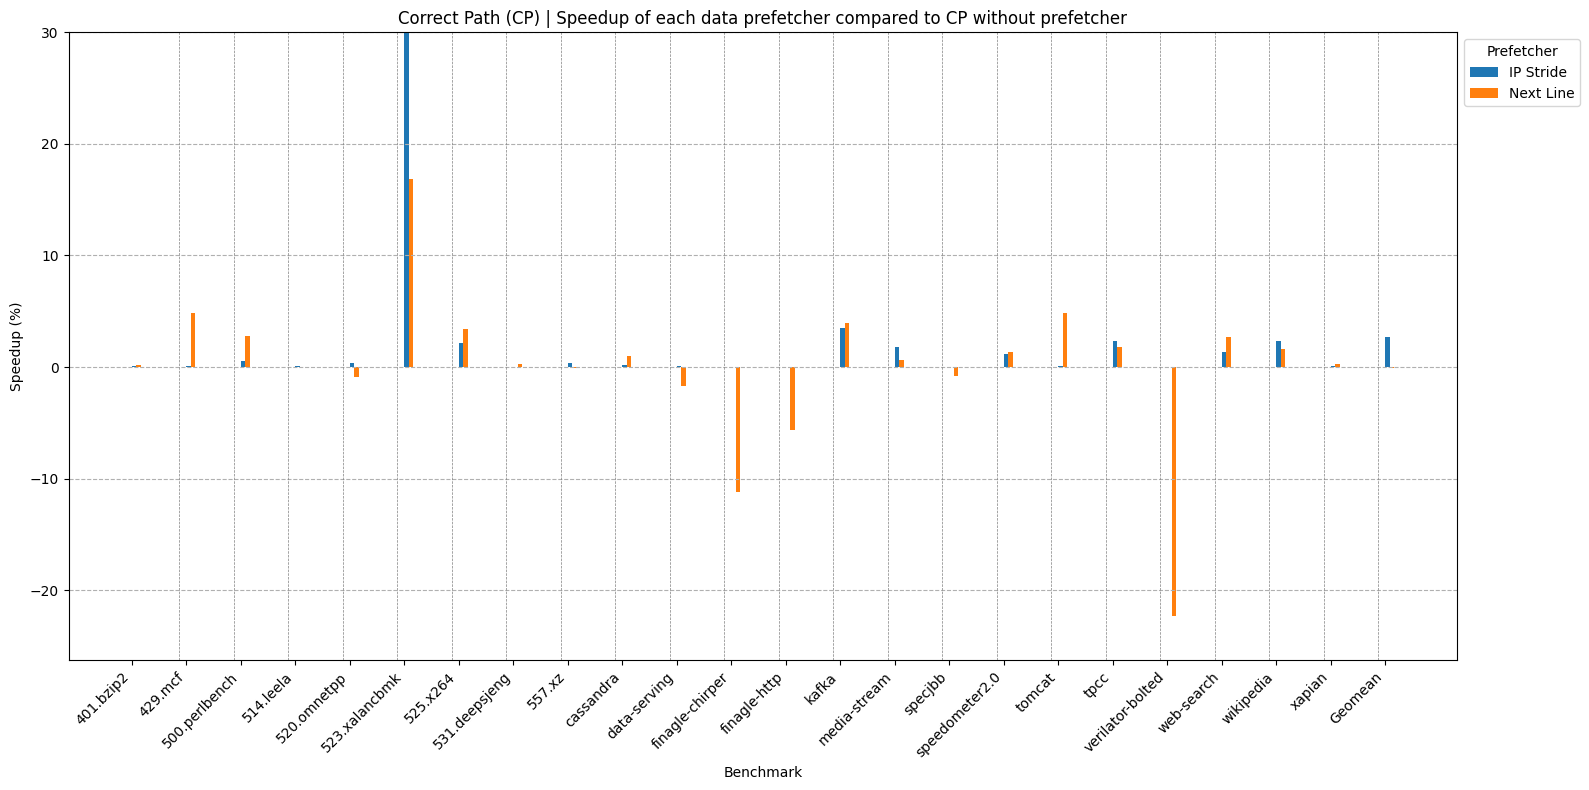

In [56]:
# Group data by prefetcher and calculate speedup
df_speedup_cp = {}
df_cp_default = group_by(cp_ipc_df, "default")
for key in llc_prefetchers:
    if key != "default":
        df_cp = group_by(cp_ipc_df, key)
        df_speedup_cp[key] = calculate_speedup(df_cp, df_cp_default)

# Create positions for each bar group
r_base = [x * (1 + gap) for x in range(len(df_cp_default))]
r_positions = {}
for idx, key in enumerate(llc_prefetchers):
    r_positions[key] = [x + idx * bar_width for x in r_base]

# Create the plot
plt.figure(figsize=(16, 8))

# Plot each prefetcher
for key, props in llc_prefetchers.items():
    if key != "default":
        plt.bar(
            r_positions[key],
            df_speedup_cp[key]["Speedup"],
            width=bar_width,
            label=props["label"],
        )

# Add vertical dashed lines between groups
for i in range(1, len(r_base)):
    plt.axvline(x=(r_base[i] - gap / 2), color="gray", linestyle="--", linewidth=0.5)

# Add labels and title
plt.grid(axis="y", linestyle="--")
plt.xticks(
    [r + (len(llc_prefetchers) - 2) * bar_width / 2 for r in r_base],
    df_cp_default["Benchmark"],
    rotation=45,
    ha="right",
)
plt.xlabel("Benchmark")
plt.ylabel("Speedup (%)")
plt.ylim(top=30)
plt.legend(title="Prefetcher", bbox_to_anchor=(1, 1), loc="upper left")
plt.title(
    "Correct Path (CP) | Speedup of each data prefetcher compared to CP without prefetcher"
)
plt.tight_layout()
plt.show()

### Wrong Path

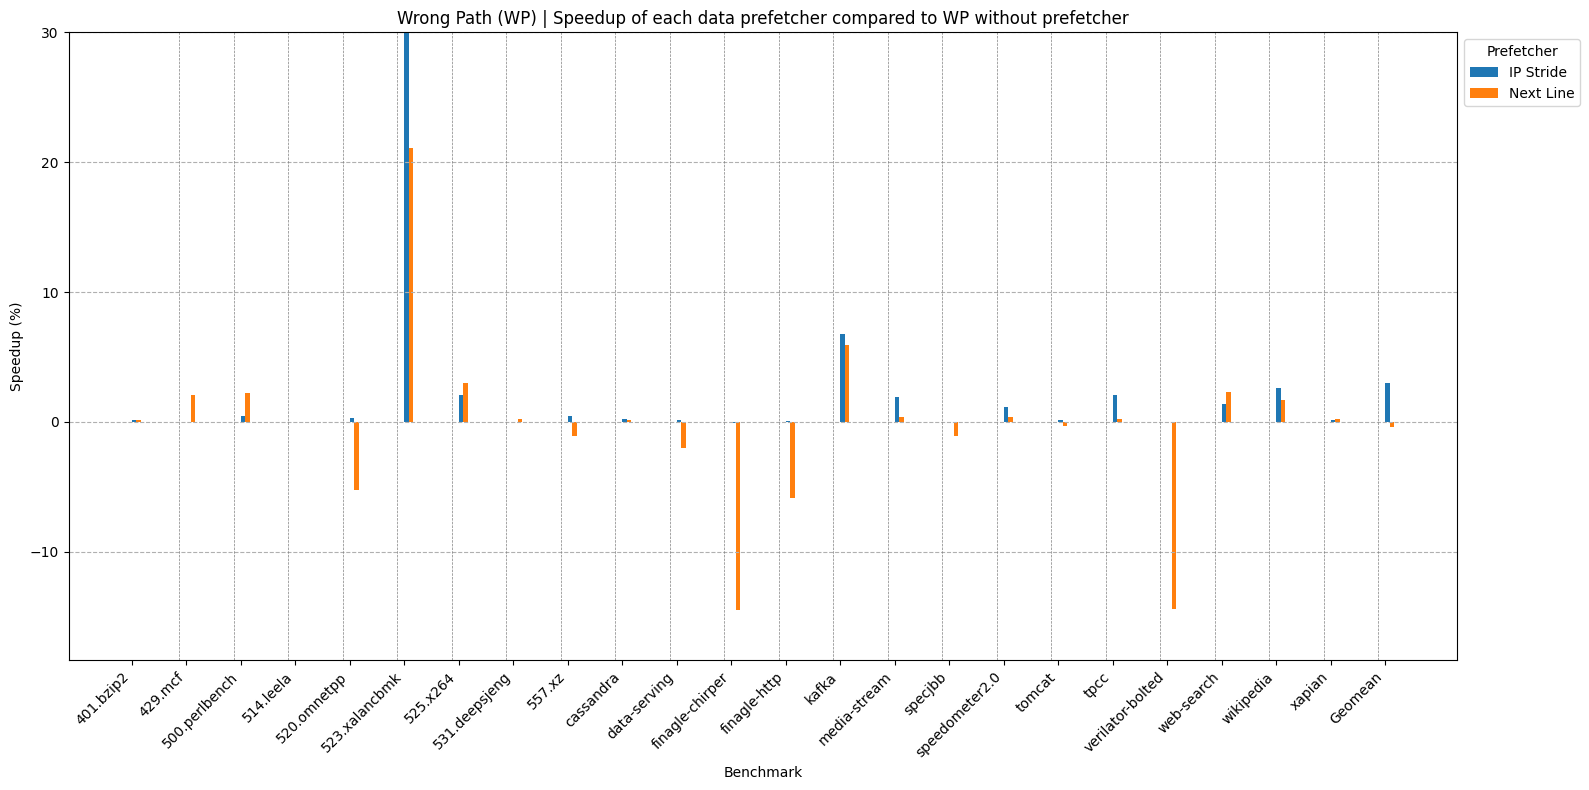

In [57]:
# Group data by prefetcher and calculate speedup
df_speedup_wp = {}
df_wp_default = group_by(wp_ipc_df, "default")
for key in llc_prefetchers:
    if key != "default":
        df_wp = group_by(wp_ipc_df, key)
        df_speedup_wp[key] = calculate_speedup(df_wp, df_wp_default)

# Create positions for each bar group
r_base = [x * (1 + gap) for x in range(len(df_wp_default))]
r_positions = {}
for idx, key in enumerate(llc_prefetchers):
    r_positions[key] = [x + idx * bar_width for x in r_base]

# Create the plot
plt.figure(figsize=(16, 8))

# Plot each prefetcher
for key, props in llc_prefetchers.items():
    if key != "default":
        plt.bar(
            r_positions[key],
            df_speedup_wp[key]["Speedup"],
            width=bar_width,
            label=props["label"],
        )

# Add vertical dashed lines between groups
for i in range(1, len(r_base)):
    plt.axvline(x=(r_base[i] - gap / 2), color="gray", linestyle="--", linewidth=0.5)

# Add labels and title
plt.grid(axis="y", linestyle="--")
plt.xticks(
    [r + (len(llc_prefetchers) - 2) * bar_width / 2 for r in r_base],
    df_wp_default["Benchmark"],
    rotation=45,
    ha="right",
)
plt.xlabel("Benchmark")
plt.ylabel("Speedup (%)")
plt.ylim(top=30)
plt.legend(title="Prefetcher", bbox_to_anchor=(1, 1), loc="upper left")
plt.title(
    "Wrong Path (WP) | Speedup of each data prefetcher compared to WP without prefetcher"
)
plt.tight_layout()
plt.show()

### WP Prefetchers v CP Baseline

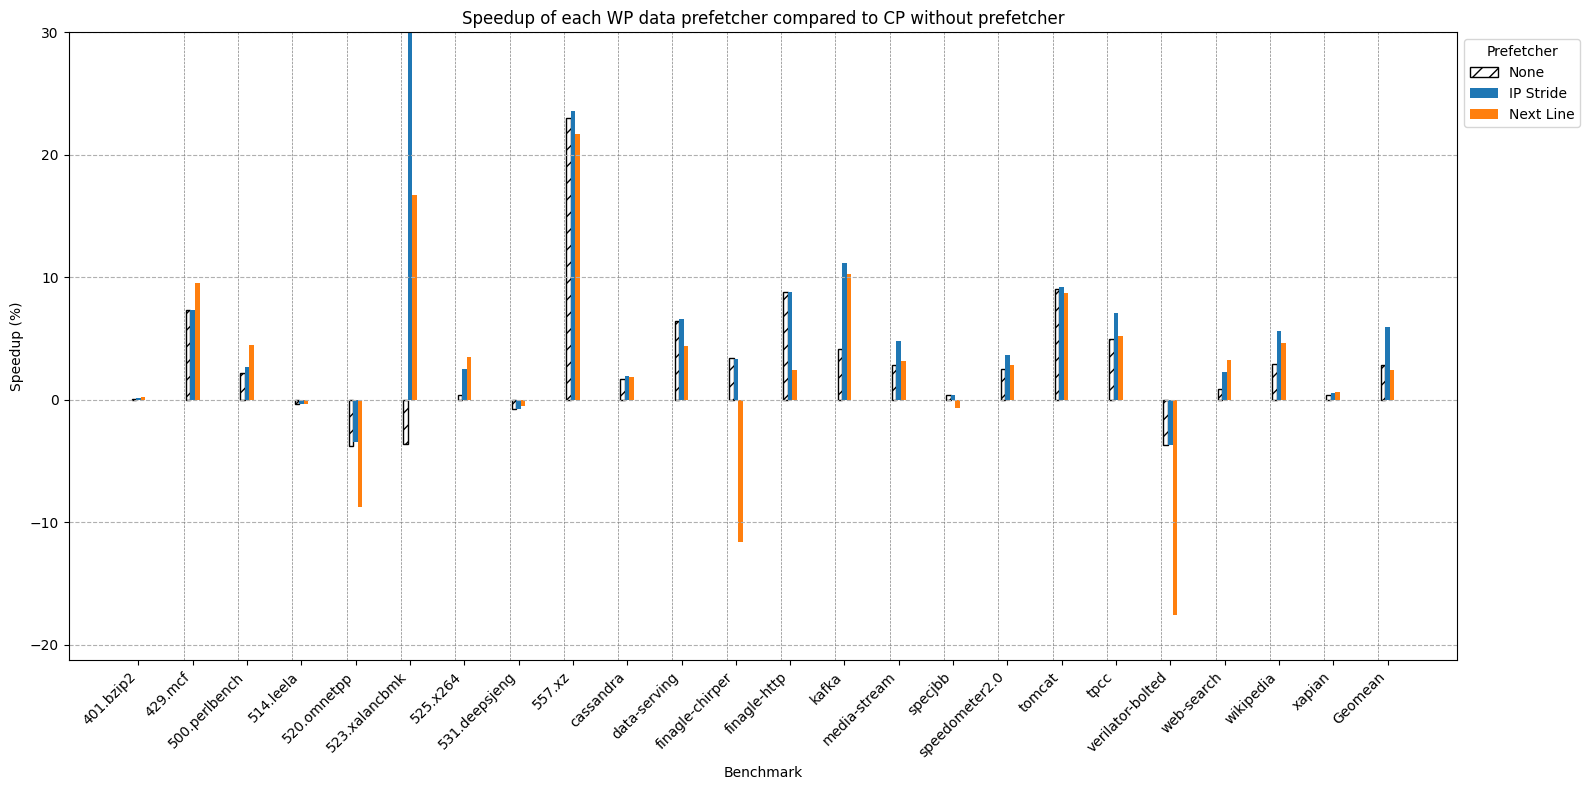

In [58]:
# Group data by prefetcher and calculate speedup
df_cp_default = group_by(cp_ipc_df, "default")
df_speedup_wp = {}
for key in llc_prefetchers:
    df_wp = group_by(wp_ipc_df, key)
    df_speedup_wp[key] = calculate_speedup(df_wp, df_cp_default)

# Create positions for each bar group
r_base = [x * (1 + gap) for x in range(len(df_cp_default))]
r_positions = {}
for idx, key in enumerate(llc_prefetchers):
    r_positions[key] = [x + idx * bar_width for x in r_base]

# Create the plot
plt.figure(figsize=(16, 8))

# Plot each prefetcher
for key, props in llc_prefetchers.items():
    color = props.get("color", None)
    edgecolor = props.get("edgecolor", None)
    hatch = props.get("hatch", None)
    plt.bar(
        r_positions[key],
        df_speedup_wp[key]["Speedup"],
        width=bar_width,
        label=props["label"],
        color=color,
        edgecolor=edgecolor,
        hatch=hatch,
    )

# Add vertical dashed lines between groups
for i in range(1, len(r_base)):
    plt.axvline(x=(r_base[i] - gap / 2), color="gray", linestyle="--", linewidth=0.5)

# Add labels and title
plt.grid(axis="y", linestyle="--")
plt.xticks(
    [r + (len(llc_prefetchers) - 1) * bar_width / 2 for r in r_base],
    df_cp_default["Benchmark"],
    rotation=45,
    ha="right",
)
plt.xlabel("Benchmark")
plt.ylabel("Speedup (%)")
plt.ylim(top=30)
plt.legend(title="Prefetcher", bbox_to_anchor=(1, 1), loc="upper left")
plt.title("Speedup of each WP data prefetcher compared to CP without prefetcher")
plt.tight_layout()
plt.show()

### WP Prefetchers V CP Prefetchers

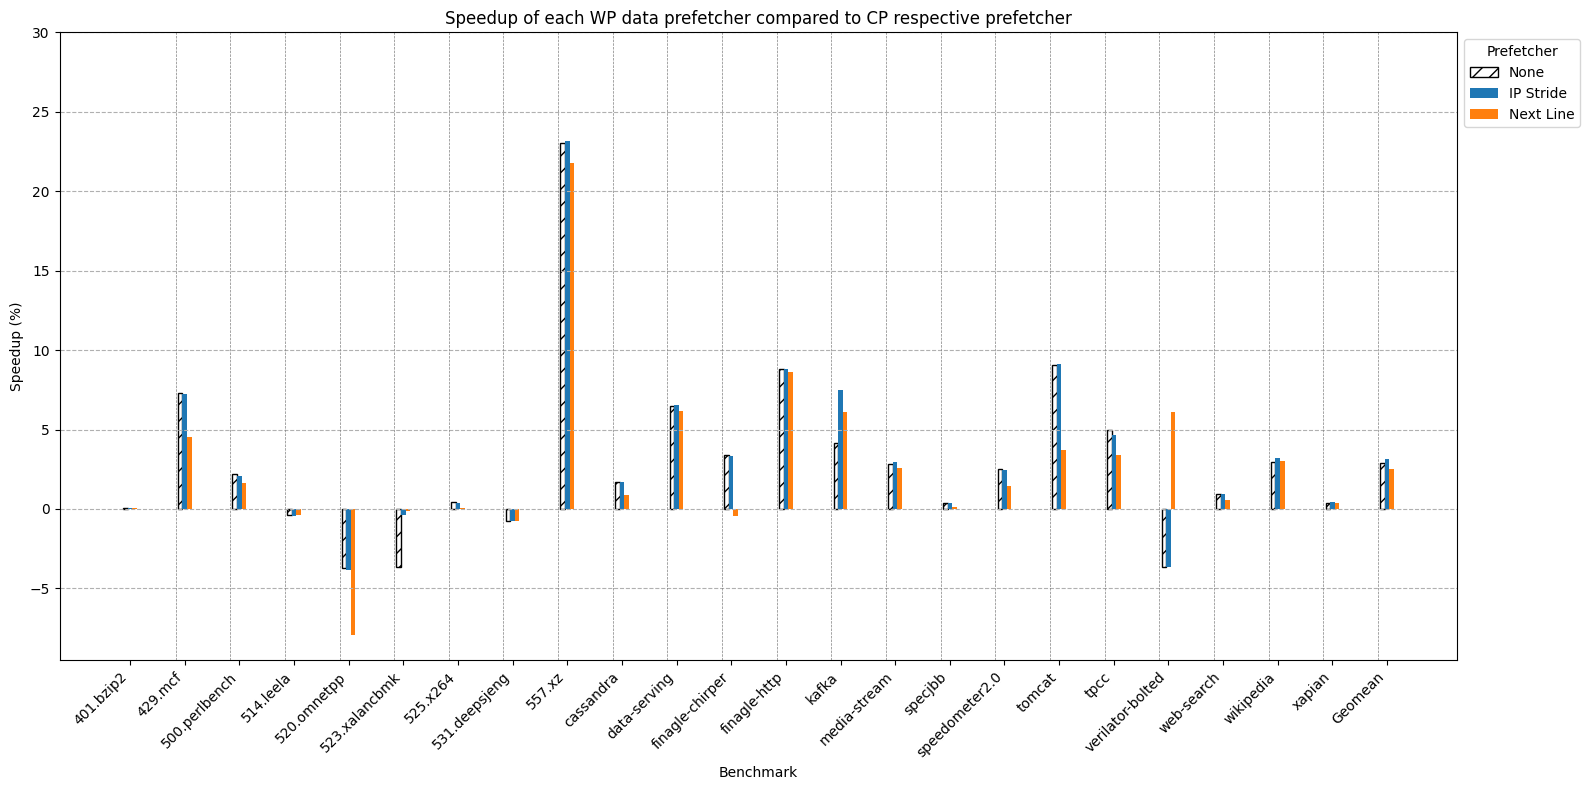

In [59]:
# Group data by prefetcher and calculate speedup
df_speedup_wp = {}
for key in llc_prefetchers:
    df_wp = group_by(wp_ipc_df, key)
    df_cp = group_by(cp_ipc_df, key)
    df_speedup_wp[key] = calculate_speedup(df_wp, df_cp)

# Create positions for each bar group
r_base = [x * (1 + gap) for x in range(len(df_speedup_wp["default"]))]
r_positions = {}
for idx, key in enumerate(llc_prefetchers):
    r_positions[key] = [x + idx * bar_width for x in r_base]

# Create the plot
plt.figure(figsize=(16, 8))

# Plot each prefetcher
for key, props in llc_prefetchers.items():
    color = props.get("color", None)
    edgecolor = props.get("edgecolor", None)
    hatch = props.get("hatch", None)
    plt.bar(
        r_positions[key],
        df_speedup_wp[key]["Speedup"],
        width=bar_width,
        label=props["label"],
        color=color,
        edgecolor=edgecolor,
        hatch=hatch,
    )

# Add vertical dashed lines between groups
for i in range(1, len(r_base)):
    plt.axvline(x=(r_base[i] - gap / 2), color="gray", linestyle="--", linewidth=0.5)

# Add labels and title
plt.grid(axis="y", linestyle="--")
plt.xticks(
    [r + (len(llc_prefetchers) - 1) * bar_width / 2 for r in r_base],
    df_speedup_wp["default"]["Benchmark"],
    rotation=45,
    ha="right",
)
plt.xlabel("Benchmark")
plt.ylabel("Speedup (%)")
plt.ylim(top=30)
plt.legend(title="Prefetcher", bbox_to_anchor=(1, 1), loc="upper left")
plt.title("Speedup of each WP data prefetcher compared to CP respective prefetcher")
plt.tight_layout()
plt.show()

## LLC Replacment Policy

In [60]:
llc_replacement_policies = {
    "default": {"label": "LRU", "color": "white", "edgecolor": "black", "hatch": "//"},
    "ship": {"label": "SHIP"},
    "srrip": {"label": "SRRIP"},
    "drrip": {"label": "DRRIP"},
    "mockingjay": {"label": "Mockingjay"},
}

### Correct Path

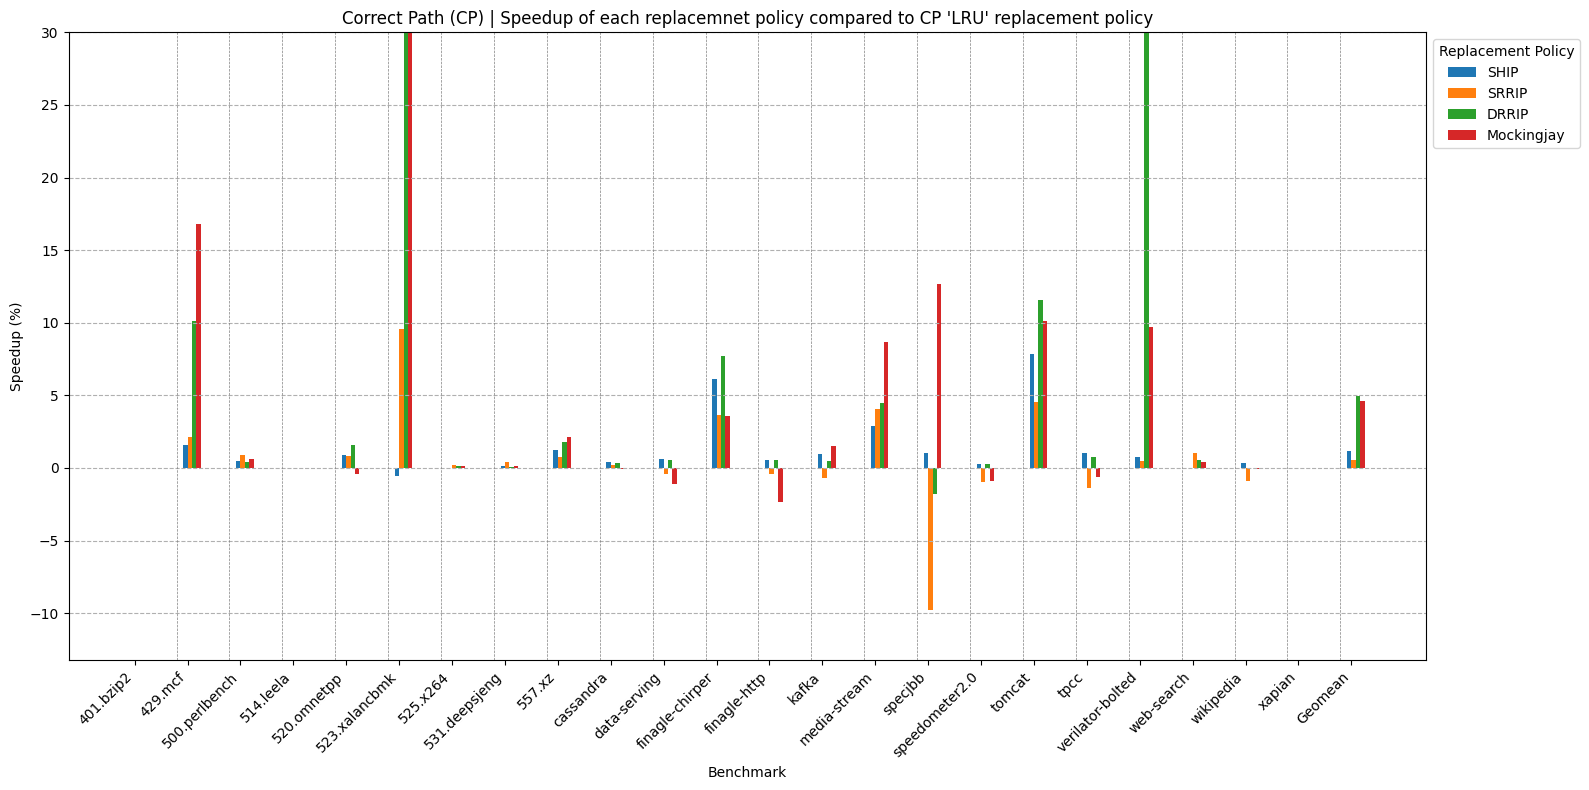

In [61]:
# Group data by replacement policy and calculate speedup
df_speedup_cp = {}
df_cp_default = group_by(cp_ipc_df, "default")
for key in llc_replacement_policies:
    if key != "default":
        df_cp = group_by(cp_ipc_df, key)
        df_speedup_cp[key] = calculate_speedup(df_cp, df_cp_default)

# Create positions for each bar group
r_base = [x * (1 + gap) for x in range(len(df_cp_default))]
r_positions = {}
for idx, key in enumerate(llc_replacement_policies):
    r_positions[key] = [x + idx * bar_width for x in r_base]

# Create the plot
plt.figure(figsize=(16, 8))

# Plot each replacement policy
for key, props in llc_replacement_policies.items():
    if key != "default":
        plt.bar(
            r_positions[key],
            df_speedup_cp[key]["Speedup"],
            width=bar_width,
            label=props["label"],
        )

# Add vertical dashed lines between groups
for i in range(1, len(r_base)):
    plt.axvline(x=(r_base[i] - gap / 2), color="gray", linestyle="--", linewidth=0.5)

# Add labels and title
plt.grid(axis="y", linestyle="--")
plt.xticks(
    [r + (len(llc_replacement_policies) - 2) * bar_width / 2 for r in r_base],
    df_cp_default["Benchmark"],
    rotation=45,
    ha="right",
)
plt.xlabel("Benchmark")
plt.ylabel("Speedup (%)")
plt.ylim(top=30)
plt.legend(title="Replacement Policy", bbox_to_anchor=(1, 1), loc="upper left")
plt.title(
    "Correct Path (CP) | Speedup of each replacemnet policy compared to CP 'LRU' replacement policy"
)
plt.tight_layout()
plt.show()

### Wrong Path

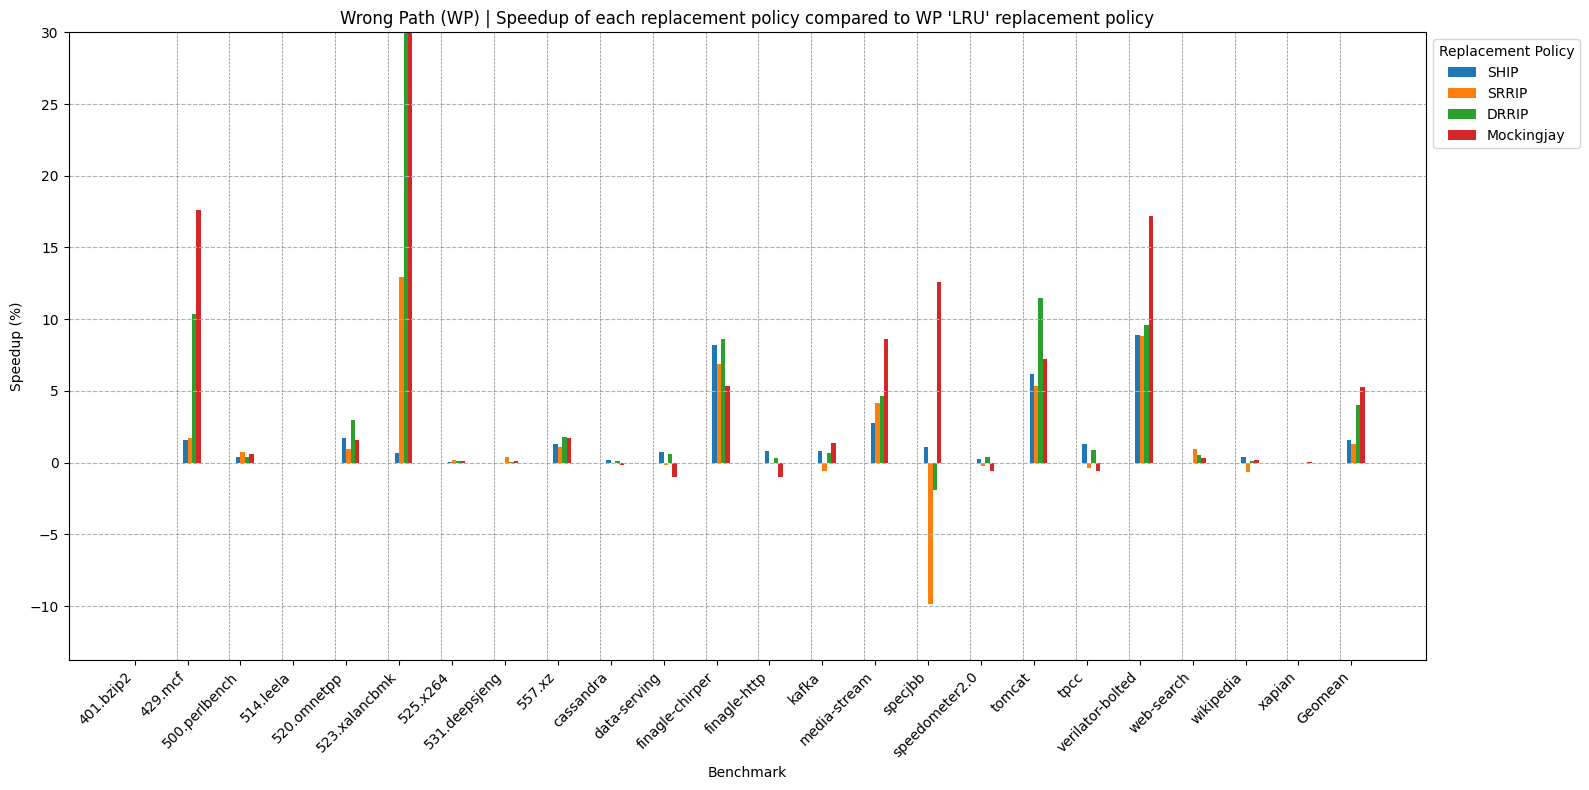

In [62]:
# Group data by replacement policy and calculate speedup
df_speedup_wp = {}
df_wp_default = group_by(wp_ipc_df, "default")
for key in llc_replacement_policies:
    if key != "default":
        df_wp = group_by(wp_ipc_df, key)
        df_speedup_wp[key] = calculate_speedup(df_wp, df_wp_default)

# Create positions for each bar group
r_base = [x * (1 + gap) for x in range(len(df_wp_default))]
r_positions = {}
for idx, key in enumerate(llc_replacement_policies):
    r_positions[key] = [x + idx * bar_width for x in r_base]

# Create the plot
plt.figure(figsize=(16, 8))

# Plot each replacement policy
for key, props in llc_replacement_policies.items():
    if key != "default":
        plt.bar(
            r_positions[key],
            df_speedup_wp[key]["Speedup"],
            width=bar_width,
            label=props["label"],
        )

# Add vertical dashed lines between groups
for i in range(1, len(r_base)):
    plt.axvline(x=(r_base[i] - gap / 2), color="gray", linestyle="--", linewidth=0.5)

# Add labels and title
plt.grid(axis="y", linestyle="--")
plt.xticks(
    [r + (len(llc_replacement_policies) - 2) * bar_width / 2 for r in r_base],
    df_wp_default["Benchmark"],
    rotation=45,
    ha="right",
)
plt.xlabel("Benchmark")
plt.ylabel("Speedup (%)")
plt.ylim(top=30)
plt.legend(title="Replacement Policy", bbox_to_anchor=(1, 1), loc="upper left")
plt.title(
    "Wrong Path (WP) | Speedup of each replacement policy compared to WP 'LRU' replacement policy"
)
plt.tight_layout()
plt.show()

### WP Repl v CP Baseline

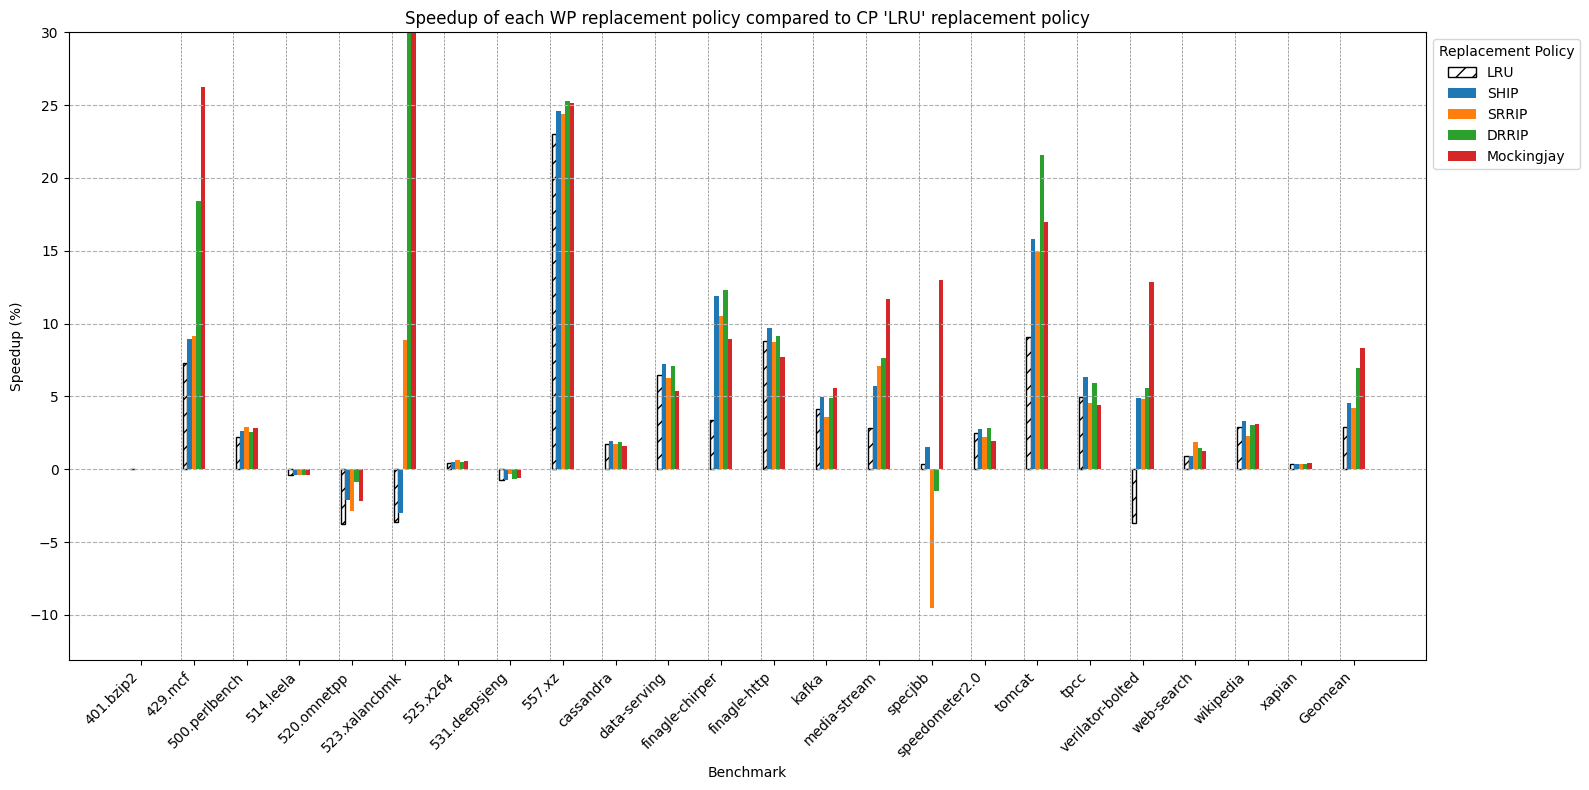

In [63]:
# Group data by replacement policy and calculate speedup
df_cp_default = group_by(cp_ipc_df, "default")
df_speedup_wp = {}
for key in llc_replacement_policies:
    df_wp = group_by(wp_ipc_df, key)
    df_speedup_wp[key] = calculate_speedup(df_wp, df_cp_default)

# Create positions for each bar group
r_base = [x * (1 + gap) for x in range(len(df_cp_default))]
r_positions = {}
for idx, key in enumerate(llc_replacement_policies):
    r_positions[key] = [x + idx * bar_width for x in r_base]

# Create the plot
plt.figure(figsize=(16, 8))

# Plot each replacement policy
for key, props in llc_replacement_policies.items():
    color = props.get("color", None)
    edgecolor = props.get("edgecolor", None)
    hatch = props.get("hatch", None)
    plt.bar(
        r_positions[key],
        df_speedup_wp[key]["Speedup"],
        width=bar_width,
        label=props["label"],
        color=color,
        edgecolor=edgecolor,
        hatch=hatch,
    )

# Add vertical dashed lines between groups
for i in range(1, len(r_base)):
    plt.axvline(x=(r_base[i] - gap / 2), color="gray", linestyle="--", linewidth=0.5)

# Add labels and title
plt.grid(axis="y", linestyle="--")
plt.xticks(
    [r + (len(llc_replacement_policies) - 1) * bar_width / 2 for r in r_base],
    df_cp_default["Benchmark"],
    rotation=45,
    ha="right",
)
plt.xlabel("Benchmark")
plt.ylabel("Speedup (%)")
plt.ylim(top=30)
plt.legend(title="Replacement Policy", bbox_to_anchor=(1, 1), loc="upper left")
plt.title(
    "Speedup of each WP replacement policy compared to CP 'LRU' replacement policy"
)
plt.tight_layout()
plt.show()

### WP Repl V CP Repl

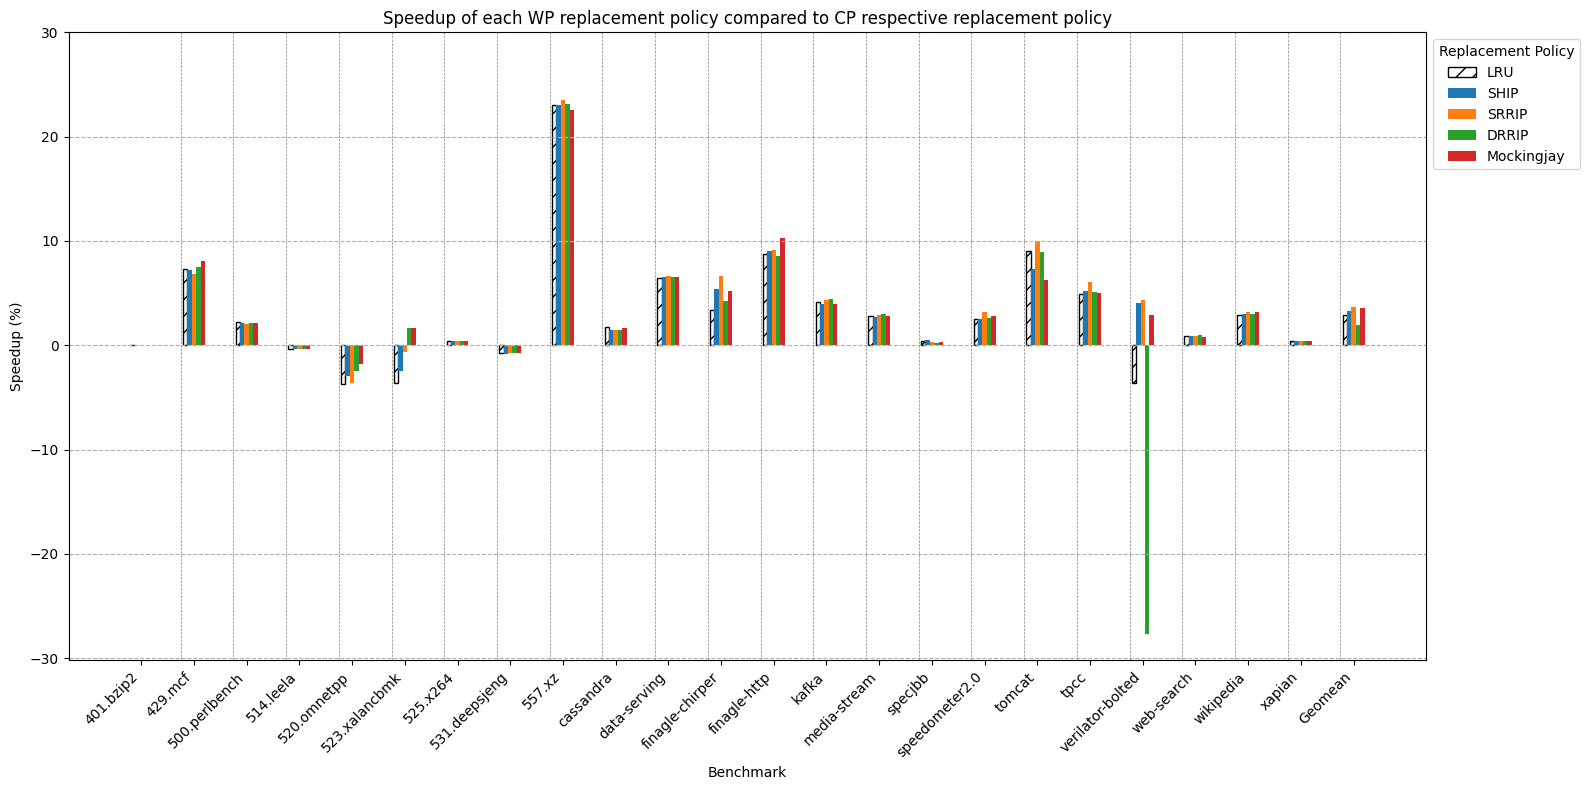

In [64]:
# Group data by replacement policy and calculate speedup
df_speedup_wp = {}
for key in llc_replacement_policies:
    df_wp = group_by(wp_ipc_df, key)
    df_cp = group_by(cp_ipc_df, key)
    df_speedup_wp[key] = calculate_speedup(df_wp, df_cp)

# Create positions for each bar group
r_base = [x * (1 + gap) for x in range(len(df_speedup_wp["default"]))]
r_positions = {}
for idx, key in enumerate(llc_replacement_policies):
    r_positions[key] = [x + idx * bar_width for x in r_base]

# Create the plot
plt.figure(figsize=(16, 8))

# Plot each replacement policy
for key, props in llc_replacement_policies.items():
    color = props.get("color", None)
    edgecolor = props.get("edgecolor", None)
    hatch = props.get("hatch", None)
    plt.bar(
        r_positions[key],
        df_speedup_wp[key]["Speedup"],
        width=bar_width,
        label=props["label"],
        color=color,
        edgecolor=edgecolor,
        hatch=hatch,
    )

# Add vertical dashed lines between groups
for i in range(1, len(r_base)):
    plt.axvline(x=(r_base[i] - gap / 2), color="gray", linestyle="--", linewidth=0.5)

# Add labels and title
plt.grid(axis="y", linestyle="--")
plt.xticks(
    [r + (len(llc_replacement_policies) - 1) * bar_width / 2 for r in r_base],
    df_speedup_wp["default"]["Benchmark"],
    rotation=45,
    ha="right",
)
plt.xlabel("Benchmark")
plt.ylabel("Speedup (%)")
plt.ylim(top=30)
plt.legend(title="Replacement Policy", bbox_to_anchor=(1, 1), loc="upper left")
plt.title(
    "Speedup of each WP replacement policy compared to CP respective replacement policy"
)
plt.tight_layout()
plt.show()